# **Home Credit Scorecard Model**
**Virtual Internship Program - Data Scientist (Home Credit Indonesia)**

### ***- Problem Statement***

Banyak individu mengalami kesulitan dalam mendapat pinjaman akibat riwayat kredit yang tidak adekuat atau bahkan tidak ada. Populasi ini sering menjadi sasaran pemberi pinjaman yang tidak bertanggung jawab.

Home Credit berinisiatif untuk memperluas akses keuangan bagi individu yang tidak memiliki rekening bank, dengan menyediakan pengalaman pinjam meminjam yang aman dan positif. Home Credit memanfaatkan data alternatif, termasuk data telekomunikasi dan transaksional, untuk mengevaluasi kemampuan pembayaran klien.

Menggunakan metode statistik dan *machine learning*, Home Credit berusaha memastikan bahwa orang-orang yang sebenarnya mampu membayar tidak ditolak dan mendapatkan pinjaman dengan syarat yang mendukung keberhasilan mereka.

### ***- Goal***
Meminimalkan jumlah klien yang ditolak namun sebenarnya mampu melunasi pinjaman.

### ***- Objective***
Mengembangkan model prediktif yang dapat mengidentifikasi klien potensial dan yang berisiko gagal bayar.

### ***- Business Metric***
Mengurangi Loss Given Default (LGD), yang merupakan jumlah kerugian finansial yang ditanggung oleh institusi keuangan ketika seorang peminjam tidak dapat melunasi pinjaman, dinyatakan sebagai persen dari total nilai pinjaman pada saat kegagalan pembayaran.

Source: [Investopedia.com - What Does Loss Given Default Mean?](https://https://www.investopedia.com/terms/l/lossgivendefault.asp#:~:text=Loss%20Given%20Default%20(LGD)%20FAQs,-What%20Does%20Loss&text=Given%20Default%20Mean%3F-,Loss%20given%20default%20(LGD)%20is%20the%20amount%20of%20money%20a,at%20the%20time%20of%20loss)

Asumsi: kerugian akibat tunggakan hanya dihitung dari total kredit klien.

### ***- Model Evaluation***
Pengukuran kinerja model dilakukan dengan menghitung area di bawah kurva ROC, yang membandingkan probabilitas prediksi dengan kenyataan pembayaran klien.

### **Pemilihan Data**

Dalam proses pemodelan, tiga berkas data telah dipilih, yaitu:

1. **application_train**: Berisi data aplikasi kredit terkini beserta variabel TARGET biner. Setiap pinjaman memiliki barisnya sendiri yang diidentifikasi melalui fitur SK_ID_CURR.

2. **bureau**: Mencakup seluruh riwayat kredit sebelumnya dari klien yang dilaporkan ke Biro Kredit (untuk klien yang memiliki pinjaman dalam sampel kita). Untuk setiap pinjaman dalam sampel, terdapat baris sebanyak jumlah kredit yang pernah dimiliki klien di Biro Kredit sebelum tanggal aplikasi.

3. **previous_application**: Memuat semua aplikasi pinjaman Home Credit sebelumnya dari klien yang memiliki pinjaman dalam sampel. Setiap baris mewakili satu aplikasi sebelumnya terkait pinjaman dalam sampel data.

Selanjutnya, untuk setiap SK_ID_CURR dalam dataset **application_test**, akan diprediksi probabilitas dari variabel TARGET.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **Import Library**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn import over_sampling
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import uniform
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

### **Prepare The Dataset**

#### Read The csv Files

##### application_train.csv

In [ ]:
main = pd.read_csv('/content/drive/MyDrive/home-credit-default-risk/application_train.csv')
main

In [ ]:
main['SK_ID_CURR'].nunique()

##### application_test.csv

In [ ]:
test = pd.read_csv('/content/drive/MyDrive/home-credit-default-risk/application_test.csv')
test

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,456221,Cash loans,F,N,Y,0,121500.0,412560.0,17473.5,270000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
48740,456222,Cash loans,F,N,N,2,157500.0,622413.0,31909.5,495000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
48741,456223,Cash loans,F,Y,Y,1,202500.0,315000.0,33205.5,315000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,3.0,1.0
48742,456224,Cash loans,M,N,N,0,225000.0,450000.0,25128.0,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0


In [ ]:
test['SK_ID_CURR'].nunique()

48744

##### previous_application.csv

In [ ]:
prev = pd.read_csv('/content/drive/MyDrive/home-credit-default-risk/previous_application.csv')
prev

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1670209,2300464,352015,Consumer loans,14704.290,267295.5,311400.0,0.0,267295.5,WEDNESDAY,12,...,Furniture,30.0,low_normal,POS industry with interest,365243.0,-508.0,362.0,-358.0,-351.0,0.0
1670210,2357031,334635,Consumer loans,6622.020,87750.0,64291.5,29250.0,87750.0,TUESDAY,15,...,Furniture,12.0,middle,POS industry with interest,365243.0,-1604.0,-1274.0,-1304.0,-1297.0,0.0
1670211,2659632,249544,Consumer loans,11520.855,105237.0,102523.5,10525.5,105237.0,MONDAY,12,...,Consumer electronics,10.0,low_normal,POS household with interest,365243.0,-1457.0,-1187.0,-1187.0,-1181.0,0.0
1670212,2785582,400317,Cash loans,18821.520,180000.0,191880.0,NaN,180000.0,WEDNESDAY,9,...,XNA,12.0,low_normal,Cash X-Sell: low,365243.0,-1155.0,-825.0,-825.0,-817.0,1.0


##### bureau.csv

In [ ]:
bureau = pd.read_csv('/content/drive/MyDrive/home-credit-default-risk/bureau.csv')
bureau

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.00,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.00,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.50,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.00,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.00,NaN,NaN,0.0,Consumer credit,-21,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1716423,259355,5057750,Active,currency 1,-44,0,-30.0,NaN,0.0,0,11250.00,11250.0,0.0,0.0,Microloan,-19,NaN
1716424,100044,5057754,Closed,currency 1,-2648,0,-2433.0,-2493.0,5476.5,0,38130.84,0.0,0.0,0.0,Consumer credit,-2493,NaN
1716425,100044,5057762,Closed,currency 1,-1809,0,-1628.0,-970.0,NaN,0,15570.00,NaN,NaN,0.0,Consumer credit,-967,NaN
1716426,246829,5057770,Closed,currency 1,-1878,0,-1513.0,-1513.0,NaN,0,36000.00,0.0,0.0,0.0,Consumer credit,-1508,NaN


#### Define new columns from previous_application.csv and bureau.csv

###### Total previous applications Home Credit loans of clients

In [ ]:
prev_app = prev.groupby(['SK_ID_CURR'])['SK_ID_CURR'].agg(['count']).reset_index()
prev_app.columns = ['SK_ID_CURR','TOTAL_PREV_APP']
prev_app

,SK_ID_CURR,TOTAL_PREV_APP
0,100001,1
1,100002,1
2,100003,3
3,100004,1
4,100005,2
...,...,...
338852,456251,1
338853,456252,1
338854,456253,2
338855,456254,2


##### Total of credits the client had in Credit Bureau

In [ ]:
bureau_cred = bureau.groupby(['SK_ID_CURR'])['SK_ID_CURR'].agg(['count']).reset_index()
bureau_cred.columns = ['SK_ID_CURR','TOTAL_BUREAU_LOAN']
bureau_cred

,SK_ID_CURR,TOTAL_BUREAU_LOAN
0,100001,7
1,100002,8
2,100003,4
3,100004,2
4,100005,3
...,...,...
305806,456249,13
305807,456250,3
305808,456253,4
305809,456254,1


### **Exploratory Data Analysis**
- Missing Value
- Duplicated Rows
- Column Data Type
- Feature Target Distribution
- Basic Info of The Clients


In [ ]:
df = (main.merge(prev_app, how='left', on='SK_ID_CURR')).merge(bureau_cred, how='left', on='SK_ID_CURR')
df

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,TOTAL_PREV_APP,TOTAL_BUREAU_LOAN
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,8.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,4.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,0,0,1.0,0.0,0.0,1.0,0.0,1.0,2.0,4.0
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0


#### Missing Value

In [ ]:
total = df.isnull().sum().sort_values(ascending = False)
percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
missing_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).reset_index()
missing_data.loc[missing_data['Percent'] >60]

,index,Total,Percent
0,COMMONAREA_MODE,214865,69.872297
1,COMMONAREA_AVG,214865,69.872297
2,COMMONAREA_MEDI,214865,69.872297
3,NONLIVINGAPARTMENTS_AVG,213514,69.432963
4,NONLIVINGAPARTMENTS_MODE,213514,69.432963
5,NONLIVINGAPARTMENTS_MEDI,213514,69.432963
6,FONDKAPREMONT_MODE,210295,68.386172
7,LIVINGAPARTMENTS_MEDI,210199,68.354953
8,LIVINGAPARTMENTS_AVG,210199,68.354953
9,LIVINGAPARTMENTS_MODE,210199,68.354953


In [ ]:
(missing_data.loc[missing_data['Percent'] >0]).shape

(69, 3)

- Dataframe has 124 columns. There are 69 columns that have missing values.
- Later, we will try to drop columns that have more than 60% of missing values

#### Duplicated Rows

In [ ]:
df.duplicated().sum()

0

There is no duplicate data

#### Column Data Type

In [ ]:
df.dtypes.value_counts()

float64    67
int64      41
object     16
dtype: int64

In [ ]:
df.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

Most of the categorical variables have a relatively small number of unique entries. Later, we will conduct feature encoding to deal with these categorical variables.

#### Feature Target Distribution


- 1: the client had payment difficulties
- 0: loan was repaid on time

In [ ]:
df['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

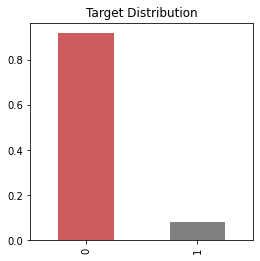

In [ ]:
df['TARGET'].value_counts(normalize=True).plot.bar(figsize=(4,4), title= 'Target Distribution', color=['indianred','grey'])
plt.show()

We see this is an imbalanced class problem. There are far more loans that were repaid on time than loans that were not repaid. Later we will conduct oversampling or undersampling.

#### Basic Info of The Clients

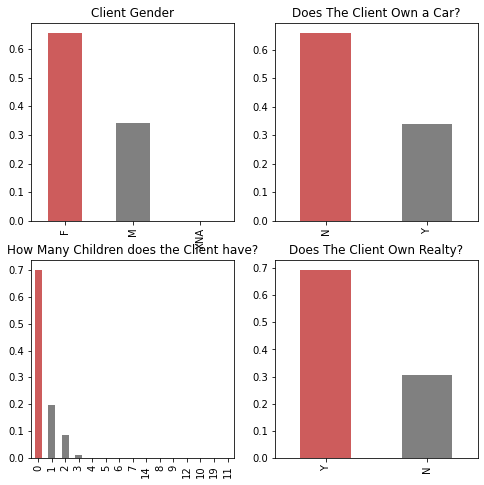

In [ ]:
plt.figure(1)
plt.subplot(221)
df['CODE_GENDER'].value_counts(normalize=True).plot.bar(figsize=(8,8), title= 'Client Gender', color=['indianred','grey'])
plt.subplot(222)
df['FLAG_OWN_CAR'].value_counts(normalize=True).plot.bar(title= 'Does The Client Own a Car?', color=['indianred','grey'])
plt.subplot(223)
df['CNT_CHILDREN'].value_counts(normalize=True).plot.bar(title= 'How Many Children does the Client have?', color=['indianred','grey','grey','grey'])
plt.subplot(224)
df['FLAG_OWN_REALTY'].value_counts(normalize=True).plot.bar(figsize=(8,8), title= 'Does The Client Own Realty?', color=['indianred','grey'])

plt.show()

- Most clients were female and without any children
- Most of the clients owned a realty but not a car

In [ ]:
df['CODE_GENDER'].value_counts()

F      202448
M      105059
XNA         4
Name: CODE_GENDER, dtype: int64

In [ ]:
df['CNT_CHILDREN'].value_counts()

0     215371
1      61119
2      26749
3       3717
4        429
5         84
6         21
7          7
14         3
8          2
9          2
12         2
10         2
19         2
11         1
Name: CNT_CHILDREN, dtype: int64

In [ ]:
df['FLAG_OWN_CAR'].value_counts()

N    202924
Y    104587
Name: FLAG_OWN_CAR, dtype: int64

In [ ]:
df['FLAG_OWN_REALTY'].value_counts()

Y    213312
N     94199
Name: FLAG_OWN_REALTY, dtype: int64

#### External Source

##### EXT_SOURCE 1

In [ ]:
df['EXT_SOURCE_1'].describe()

count    134133.000000
mean          0.502130
std           0.211062
min           0.014568
25%           0.334007
50%           0.505998
75%           0.675053
max           0.962693
Name: EXT_SOURCE_1, dtype: float64

In [ ]:
data_EX1 = df[['TARGET', 'EXT_SOURCE_1']]
data_EX1['EXT_SOURCE_1_GROUP'] = pd.cut(data_EX1['EXT_SOURCE_1'], bins = np.linspace(0, 1, num=6))
data_EX1 = (data_EX1.groupby(['EXT_SOURCE_1_GROUP']).mean()).sort_values('TARGET')
data_EX1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,TARGET,EXT_SOURCE_1
EXT_SOURCE_1_GROUP,,
"(0.8, 1.0]",0.024551,0.846599
"(0.6, 0.8]",0.041637,0.696240
"(0.4, 0.6]",0.064229,0.500625
"(0.2, 0.4]",0.103121,0.305683
"(0.0, 0.2]",0.182317,0.141402


<BarContainer object of 5 artists>

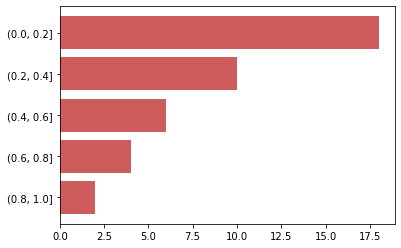

In [ ]:
plt.barh(data_EX1.index.astype(str), round(100*data_EX1['TARGET']), color='indianred')

##### EXT_SOURCE 2

In [ ]:
df['EXT_SOURCE_2'].describe()

count    3.068510e+05
mean     5.143927e-01
std      1.910602e-01
min      8.173617e-08
25%      3.924574e-01
50%      5.659614e-01
75%      6.636171e-01
max      8.549997e-01
Name: EXT_SOURCE_2, dtype: float64

In [ ]:
data_EX2 = df[['TARGET', 'EXT_SOURCE_2']]
data_EX2['EXT_SOURCE_2_GROUP'] = pd.cut(data_EX2['EXT_SOURCE_2'], bins = np.linspace(0, 1, num=6))
data_EX2 = (data_EX2.groupby(['EXT_SOURCE_2_GROUP']).mean()).sort_values('TARGET')
data_EX2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,TARGET,EXT_SOURCE_2
EXT_SOURCE_2_GROUP,,
"(0.8, 1.0]",0.017575,0.807577
"(0.6, 0.8]",0.045715,0.681445
"(0.4, 0.6]",0.077942,0.515838
"(0.2, 0.4]",0.116156,0.306879
"(0.0, 0.2]",0.188444,0.113479


<BarContainer object of 5 artists>

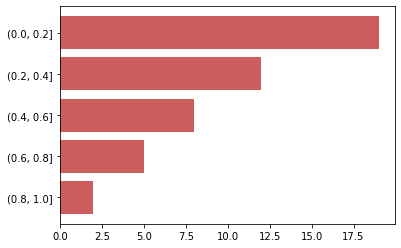

In [ ]:
plt.barh(data_EX2.index.astype(str), round(100*data_EX2['TARGET']), color='indianred')

##### EXT_SOURCE 3

In [ ]:
df['EXT_SOURCE_3'].describe()

count    246546.000000
mean          0.510853
std           0.194844
min           0.000527
25%           0.370650
50%           0.535276
75%           0.669057
max           0.896010
Name: EXT_SOURCE_3, dtype: float64

In [ ]:
data_EX3 = df[['TARGET', 'EXT_SOURCE_3']]
data_EX3['EXT_SOURCE_3_GROUP'] = pd.cut(data_EX3['EXT_SOURCE_3'], bins = np.linspace(0, 1, num=6))
data_EX3 = (data_EX3.groupby(['EXT_SOURCE_3_GROUP']).mean()).sort_values('TARGET')
data_EX3

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,TARGET,EXT_SOURCE_3
EXT_SOURCE_3_GROUP,,
"(0.8, 1.0]",0.028729,0.825140
"(0.6, 0.8]",0.039989,0.691383
"(0.4, 0.6]",0.065192,0.506095
"(0.2, 0.4]",0.117779,0.311368
"(0.0, 0.2]",0.209439,0.128083


<BarContainer object of 5 artists>

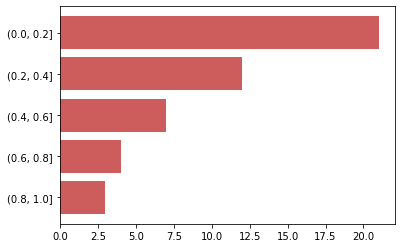

In [ ]:
plt.barh(data_EX3.index.astype(str), round(100*data_EX3['TARGET']), color='indianred')

### **Data Preprocessing Data Training**
- Feature Engineering
- Replace XNA values with NaN
- Missing Values (Drop and Imputation)
- Scaling Numerical Features
- Feature Encoding

In [ ]:
df = (main.merge(prev_app, how='left', on='SK_ID_CURR')).merge(bureau_cred, how='left', on='SK_ID_CURR')
df

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,TOTAL_PREV_APP,TOTAL_BUREAU_LOAN
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,8.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,4.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,0,0,1.0,0.0,0.0,1.0,0.0,1.0,2.0,4.0
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0


#### Feature Engineering

1. **Converting DAYS_BIRTH to years to get client age**

    The numbers in the DAYS_BIRTH column are negative because they are recorded relative to the current loan application. To see these stats in years, we will divide by negative of the number of days in a year

In [ ]:
df['AGE'] = df['DAYS_BIRTH']/-365
df.drop(columns='DAYS_BIRTH', inplace=True)

In [ ]:
data_age = df[['TARGET', 'AGE']]
data_age['AGE_GROUP'] = pd.cut(data_age['AGE'], bins = np.linspace(20, 70, num=6))
data_age = (data_age.groupby(['AGE_GROUP']).mean()).sort_values('TARGET')
data_age

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,TARGET,AGE
AGE_GROUP,,
"(60.0, 70.0]",0.049214,63.355933
"(50.0, 60.0]",0.061297,54.976575
"(40.0, 50.0]",0.076508,44.756079
"(30.0, 40.0]",0.095835,35.123197
"(20.0, 30.0]",0.114569,26.622041


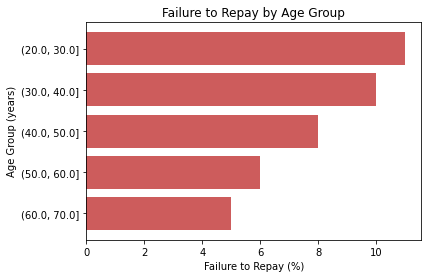

In [ ]:
plt.barh(data_age.index.astype(str), round(100*data_age['TARGET']), color='indianred')

plt.ylabel('Age Group (years)')
plt.xlabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');
plt.show()

Younger clients are more likely to not repay the loan. The rate of failure to repay is above 10% for the youngest age groups and below 5% for the oldest age group.

This is information that could be directly used by the bank: because younger clients are less likely to repay the loan, maybe they should be provided with more guidance or financial planning tips. This does not mean the bank should discriminate against younger clients, but it would be smart to take precautionary measures to help younger clients pay on time.

2. **Converting DAYS_EMPLOYED to years**

DAYS_EMPLOYED: How many days before the application the person started current employment

In [ ]:
df['YEARS_EMPLOYED'] = df['DAYS_EMPLOYED']/-365
df.drop(columns='DAYS_EMPLOYED', inplace=True)

df['YEARS_EMPLOYED'].describe()

count    307511.000000
mean       -174.835742
std         387.056895
min       -1000.665753
25%           0.791781
50%           3.323288
75%           7.561644
max          49.073973
Name: YEARS_EMPLOYED, dtype: float64

That doesn't look right! The minimum value (besides being negative) is about 1000 years!

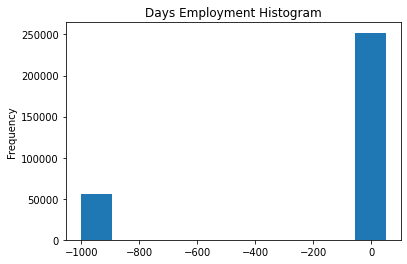

In [ ]:
df['YEARS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');

Replace the wrong values with not a number (np.nan)

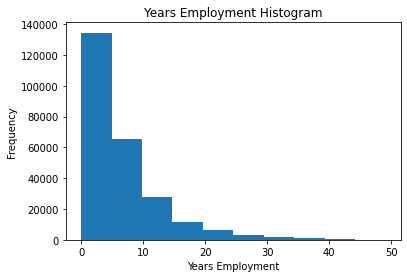

In [ ]:
df['YEARS_EMPLOYED'].replace({df['YEARS_EMPLOYED'].min(): np.nan}, inplace=True)
df['YEARS_EMPLOYED'].plot.hist(title = 'Years Employment Histogram');
plt.xlabel('Years Employment');

In [ ]:
data_employed = df[['TARGET', 'YEARS_EMPLOYED','AGE']]
data_employed['YEARS_EMPLOYED_GROUP'] = pd.cut(data_employed['YEARS_EMPLOYED'], bins = np.linspace(0, 50, num=6))
data_employed = ((data_employed.groupby(['YEARS_EMPLOYED_GROUP']).mean())).sort_values('TARGET')
data_employed

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,TARGET,YEARS_EMPLOYED,AGE
YEARS_EMPLOYED_GROUP,,,
"(40.0, 50.0]",0.004274,42.419588,62.777719
"(30.0, 40.0]",0.034645,33.725897,55.769764
"(20.0, 30.0]",0.044917,23.945354,49.161998
"(10.0, 20.0]",0.055133,13.662366,44.636523
"(0.0, 10.0]",0.095392,3.928111,39.017162


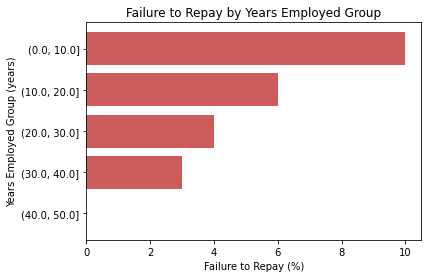

In [ ]:
plt.barh(data_employed.index.astype(str), round(100*data_employed['TARGET']), color='indianred')

plt.ylabel('Years Employed Group (years)')
plt.xlabel('Failure to Repay (%)')
plt.title('Failure to Repay by Years Employed Group');
plt.show()

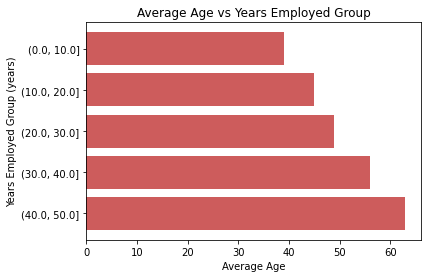

In [ ]:
plt.barh(data_employed.index.astype(str), round(data_employed['AGE']), color='indianred')

plt.ylabel('Years Employed Group (years)')
plt.xlabel('Average Age')
plt.title('Average Age vs Years Employed Group');
plt.show()

The longer the current employment of the clients are more likely to repay the loan.

3. **Converting DAYS_REGISTRATION to years**

DAYS_REGISTRATION: How many days before the application did client change his registration

In [ ]:
df['YEARS_REGISTRATION'] = df['DAYS_REGISTRATION']/-365
df.drop(columns='DAYS_REGISTRATION', inplace=True)

df['YEARS_REGISTRATION'].describe()

count    307511.000000
mean         13.660604
std           9.651743
min          -0.000000
25%           5.506849
50%          12.339726
75%          20.491781
max          67.594521
Name: YEARS_REGISTRATION, dtype: float64

In [ ]:
data_regist = df[['TARGET', 'YEARS_REGISTRATION']]
data_regist['YEARS_REGISTRATION_GROUP'] = pd.cut(data_regist['YEARS_REGISTRATION'], bins = np.linspace(0, 70, num=8))
data_regist = (data_regist.groupby(['YEARS_REGISTRATION_GROUP']).mean())
data_regist

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,TARGET,YEARS_REGISTRATION
YEARS_REGISTRATION_GROUP,,
"(0.0, 10.0]",0.089793,4.554976
"(10.0, 20.0]",0.083164,14.552255
"(20.0, 30.0]",0.066114,24.388090
"(30.0, 40.0]",0.056592,33.759017
"(40.0, 50.0]",0.038159,42.643739
"(50.0, 60.0]",0.042254,53.426973
"(60.0, 70.0]",0.111111,63.092846


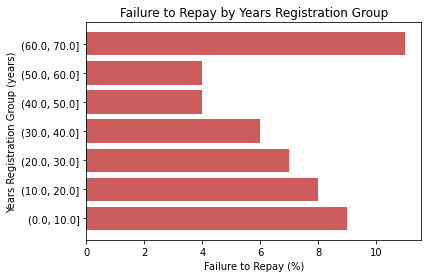

In [ ]:
plt.barh(data_regist.index.astype(str), round(100*data_regist['TARGET']), color='indianred')

plt.ylabel('Years Registration Group (years)')
plt.xlabel('Failure to Repay (%)')
plt.title('Failure to Repay by Years Registration Group');
plt.show()

4. **Converting DAYS_ID_PUBLISH to years**

DAYS_ID_PUBLISH: How many days before the application did client change the identity document with which he applied for the loan

In [ ]:
df['YEARS_ID_PUBLISH'] = df['DAYS_ID_PUBLISH']/-365
df.drop(columns='DAYS_ID_PUBLISH', inplace=True)

df['YEARS_ID_PUBLISH'].describe()

count    307511.000000
mean          8.203294
std           4.135481
min          -0.000000
25%           4.712329
50%           8.915068
75%          11.778082
max          19.717808
Name: YEARS_ID_PUBLISH, dtype: float64

In [ ]:
data_id_publish = df[['TARGET', 'YEARS_ID_PUBLISH']]
data_id_publish['YEARS_ID_PUBLISH_GROUP'] = pd.cut(data_id_publish['YEARS_ID_PUBLISH'], bins = np.linspace(0, 20, num=5))
data_id_publish = (data_id_publish.groupby(['YEARS_ID_PUBLISH_GROUP']).mean()).sort_values('TARGET')
data_id_publish

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,TARGET,YEARS_ID_PUBLISH
YEARS_ID_PUBLISH_GROUP,,
"(15.0, 20.0]",0.055633,15.727328
"(10.0, 15.0]",0.067253,12.063096
"(5.0, 10.0]",0.084554,7.541837
"(0.0, 5.0]",0.098703,2.550191


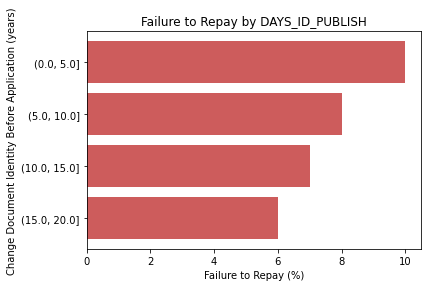

In [ ]:
plt.barh(data_id_publish.index.astype(str), round(100*data_id_publish['TARGET']), color='indianred')

plt.ylabel('Change Document Identity Before Application (years)')
plt.xlabel('Failure to Repay (%)')
plt.title('Failure to Repay by DAYS_ID_PUBLISH');
plt.show()

5. **Number of documents provided by a customer**

In [ ]:
regex = re.compile('FLAG_DOCUMENT_')
col = [i for i in df.columns if re.match(regex, i)]

In [ ]:
df['TOTAL_DOCUMENT'] = df['FLAG_DOCUMENT_2'] + df['FLAG_DOCUMENT_3'] + df['FLAG_DOCUMENT_4'] + df['FLAG_DOCUMENT_5'] + df['FLAG_DOCUMENT_6'] + df['FLAG_DOCUMENT_7'] + df['FLAG_DOCUMENT_8'] + df['FLAG_DOCUMENT_9'] + df['FLAG_DOCUMENT_10'] + df['FLAG_DOCUMENT_11'] + df['FLAG_DOCUMENT_12'] + df['FLAG_DOCUMENT_13'] + df['FLAG_DOCUMENT_14'] + df['FLAG_DOCUMENT_15'] + df['FLAG_DOCUMENT_16'] + df['FLAG_DOCUMENT_17'] + df['FLAG_DOCUMENT_18'] + df['FLAG_DOCUMENT_19'] + df['FLAG_DOCUMENT_20'] + df['FLAG_DOCUMENT_21']

In [ ]:
df.drop(columns = [i for i in df.columns if re.match(regex, i)], inplace=True)

In [ ]:
df['TOTAL_DOCUMENT'].value_counts()

1    270056
0     29549
2      7742
3       163
4         1
Name: TOTAL_DOCUMENT, dtype: int64

In [ ]:
doc_list = []
for index, column in df.iterrows():
    if column['TOTAL_DOCUMENT'] >= 1:
        doc = 1
    else:
        doc = 0
    doc_list.append(doc)

df['DOC_PROVIDED'] = doc_list

In [ ]:
doc_data = df.groupby(['DOC_PROVIDED'])['TARGET'].mean().reset_index()
doc_data

,DOC_PROVIDED,TARGET
0,0,0.055230
1,1,0.083439


In [ ]:
doc_data['DOC_PROVIDED'] = doc_data['DOC_PROVIDED'].astype('int')

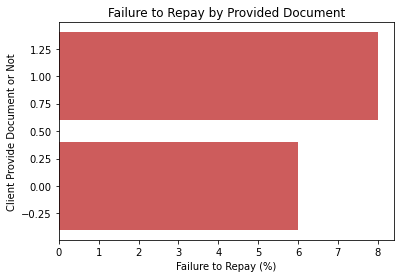

In [ ]:
plt.barh(range(0,2), round(100*doc_data['TARGET']), color='indianred')

plt.ylabel('Client Provide Document or Not')
plt.xlabel('Failure to Repay (%)')
plt.title('Failure to Repay by Provided Document')
plt.show()

6. **Income Annuity Percentage** : the percentage of the annuity relative to a client's income

An income annuity is a lifetime income guarantee that you purchase from an insurance company as a way to reduce the risk that you run out of money in retirement. Just like you insure your home, you can insure your longevity by passing on the risk that you outlive your savings to an insurance company.

Source: https://www.blueprintincome.com/resources/income-annuities/

In [ ]:
df['INCOME_ANNUITY_PERCENT'] = (df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL'])*100

In [ ]:
df['INCOME_ANNUITY_PERCENT'].describe()

count    307499.000000
mean         18.093001
std           9.457380
min           0.022388
25%          11.478182
50%          16.283333
75%          22.906667
max         187.596491
Name: INCOME_ANNUITY_PERCENT, dtype: float64

In [ ]:
income_list = []
for index, column in df.iterrows():
    if column['INCOME_ANNUITY_PERCENT'] > 150:
        income = 150
    else:
        income = column['INCOME_ANNUITY_PERCENT']
    income_list.append(income)

df['INCOME_ANNUITY_PERCENT_NEW'] = income_list

In [ ]:
income_annuity = df[['TARGET', 'INCOME_ANNUITY_PERCENT_NEW']]
income_annuity['INCOME_ANNUITY_PERCENT_NEW_GROUP'] = pd.cut(income_annuity['INCOME_ANNUITY_PERCENT_NEW'], bins = np.linspace(0, 200, num=5))
income_annuity = (income_annuity.groupby(['INCOME_ANNUITY_PERCENT_NEW_GROUP']).mean()).sort_values('TARGET')
income_annuity

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,TARGET,INCOME_ANNUITY_PERCENT_NEW
INCOME_ANNUITY_PERCENT_NEW_GROUP,,
"(50.0, 100.0]",0.074489,59.974851
"(0.0, 50.0]",0.080775,17.739247
"(100.0, 150.0]",0.151515,116.888560
"(150.0, 200.0]",NaN,NaN


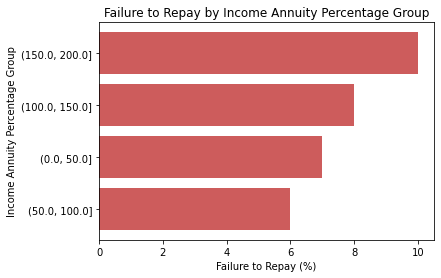

In [ ]:
plt.barh(income_annuity.index.astype(str), round(100*data_id_publish['TARGET']), color='indianred')

plt.ylabel('Income Annuity Percentage Group')
plt.xlabel('Failure to Repay (%)')
plt.title('Failure to Repay by Income Annuity Percentage Group');
plt.show()

7. **Earned Income Tax Credit (EITC)**

EITC equals a fixed percentage (the “credit rate”) of earned income until the credit reaches its maximum amount.

Source: https://sgp.fas.org/crs/misc/R43805.pdf

In [ ]:
df['EITC'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']

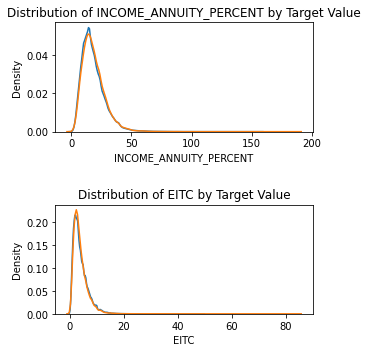

In [ ]:
plt.figure(figsize = (5,5))
# iterate through the new features
for i, feature in enumerate(['INCOME_ANNUITY_PERCENT', 'EITC']):

    # create a new subplot for each source
    plt.subplot(2, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(df.loc[df['TARGET'] == 0, feature], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(df.loc[df['TARGET'] == 1, feature], label = 'target == 1')

    # Label the plots
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature); plt.ylabel('Density');

plt.tight_layout(h_pad = 2.5)

In [ ]:
pd.set_option('display.max_columns', None)
df

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,TOTAL_PREV_APP,TOTAL_BUREAU_LOAN,AGE,YEARS_EMPLOYED,YEARS_REGISTRATION,YEARS_ID_PUBLISH,TOTAL_DOCUMENT,DOC_PROVIDED,INCOME_ANNUITY_PERCENT,INCOME_ANNUITY_PERCENT_NEW,EITC
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.0220,0.0198,0.0,0.0000,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.0000,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,8.0,25.920548,1.745205,9.994521,5.808219,1,1,12.197778,12.197778,2.007889
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.0790,0.0554,0.0,0.0000,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.0100,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,4.0,45.931507,3.254795,3.249315,0.797260,1,1,13.221667,13.221667,4.790750
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,52.180822,0.616438,11.671233,6.934247,0,0,10.000000,10.000000,2.000000
3,100006,0,Cash loa

#### Replace XNA values with NaN

‘XNA’ in the above output might be because of the incorrect information while data entry.

In [ ]:
for col in df.select_dtypes(include = ["object"]).columns:
    print(f'''Value count kolom {col}:''')
    print(df[col].value_counts())
    print()

Value count kolom NAME_CONTRACT_TYPE:
Cash loans         278232
Revolving loans     29279
Name: NAME_CONTRACT_TYPE, dtype: int64

Value count kolom CODE_GENDER:
F      202448
M      105059
XNA         4
Name: CODE_GENDER, dtype: int64

Value count kolom FLAG_OWN_CAR:
N    202924
Y    104587
Name: FLAG_OWN_CAR, dtype: int64

Value count kolom FLAG_OWN_REALTY:
Y    213312
N     94199
Name: FLAG_OWN_REALTY, dtype: int64

Value count kolom NAME_TYPE_SUITE:
Unaccompanied      248526
Family              40149
Spouse, partner     11370
Children             3267
Other_B              1770
Other_A               866
Group of people       271
Name: NAME_TYPE_SUITE, dtype: int64

Value count kolom NAME_INCOME_TYPE:
Working                 158774
Commercial associate     71617
Pensioner                55362
State servant            21703
Unemployed                  22
Student                     18
Businessman                 10
Maternity leave              5
Name: NAME_INCOME_TYPE, dtype: int64

Va

Replacing XNA in columns GENDER and ORGANIZATION_TYPE to NaN

In [ ]:
df.CODE_GENDER.replace("XNA", np.nan, inplace=True)
df.ORGANIZATION_TYPE.replace("XNA", np.nan, inplace=True)

#### Keeping columns that include less than equal to 60% of missing values

Looking into the dataset when there is more than 60% of data is missing most well-liked dropping variables when it involves taking the choice of dropping variable that variable shouldn’t impact overall analysis.

Source: https://www.analyticsvidhya.com/blog/2021/10/guide-to-deal-with-missing-values/

In [ ]:
df.shape

(307511, 109)

In [ ]:
total = df.isnull().sum().sort_values(ascending = False)
percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
missing_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).reset_index()
missing_data.loc[missing_data['Percent'] >60]

,index,Total,Percent
0,COMMONAREA_MODE,214865,69.872297
1,COMMONAREA_AVG,214865,69.872297
2,COMMONAREA_MEDI,214865,69.872297
3,NONLIVINGAPARTMENTS_AVG,213514,69.432963
4,NONLIVINGAPARTMENTS_MEDI,213514,69.432963
5,NONLIVINGAPARTMENTS_MODE,213514,69.432963
6,FONDKAPREMONT_MODE,210295,68.386172
7,LIVINGAPARTMENTS_MEDI,210199,68.354953
8,LIVINGAPARTMENTS_AVG,210199,68.354953
9,LIVINGAPARTMENTS_MODE,210199,68.354953


In [ ]:
df.drop(columns=list(missing_data['index'].loc[missing_data['Percent'] >60]),inplace=True)
df.shape

(307511, 92)

In [ ]:
pd.set_option("max_columns", None)
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,LANDAREA_AVG,LIVINGAREA_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,LANDAREA_MODE,LIVINGAREA_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,LANDAREA_MEDI,LIVINGAREA_MEDI,NONLIVINGAREA_MEDI,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,TOTAL_PREV_APP,TOTAL_BUREAU_LOAN,AGE,YEARS_EMPLOYED,YEARS_REGISTRATION,YEARS_ID_PUBLISH,TOTAL_DOCUMENT,DOC_PROVIDED,INCOME_ANNUITY_PERCENT,INCOME_ANNUITY_PERCENT_NEW,EITC
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.00,0.0690,0.0833,0.0369,0.0190,0.0000,0.0252,0.0383,0.9722,0.0000,0.0690,0.0833,0.0377,0.0198,0.0,0.0250,0.0369,0.9722,0.00,0.0690,0.0833,0.0375,0.0193,0.00,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,8.0,25.920548,1.745205,9.994521,5.808219,1,1,12.197778,12.197778,2.007889
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.08,0.0345,0.2917,0.0130,0.0549,0.0098,0.0924,0.0538,0.9851,0.0806,0.0345,0.2917,0.0128,0.0554,0.0,0.0968,0.0529,0.9851,0.08,0.0345,0.2917,0.0132,0.0558,0.01,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,4.0,45.931507,3.254795,3.249315,0.797260,1,1,13.221667,13.221667,4.790750
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,52.180822,0.616438,11.671233,6.934247,0,0,10.000000,10.000000,2.000000
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,Business Entity Type 3,NaN,0.650442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN,52.068493,8.326027,26.939726,6.676712,1,1,21.990000,21.990000,2.316167
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartm

#### Missing Value Imputation

In [ ]:
null = df.isnull().sum().reset_index()
null_table = null.loc[null[0] > 0]
null_table.shape

(57, 2)

57 columns have missing value

In [ ]:
pd.set_option("max_columns", None)
data_null = df[null_table['index'].tolist()]
data_null

,CODE_GENDER,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,OCCUPATION_TYPE,CNT_FAM_MEMBERS,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,LANDAREA_AVG,LIVINGAREA_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,LANDAREA_MODE,LIVINGAREA_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,LANDAREA_MEDI,LIVINGAREA_MEDI,NONLIVINGAREA_MEDI,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,TOTAL_PREV_APP,TOTAL_BUREAU_LOAN,YEARS_EMPLOYED,INCOME_ANNUITY_PERCENT,INCOME_ANNUITY_PERCENT_NEW
0,M,24700.5,351000.0,Unaccompanied,Laborers,1.0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.00,0.0690,0.0833,0.0369,0.0190,0.0000,0.0252,0.0383,0.9722,0.0000,0.0690,0.0833,0.0377,0.0198,0.0000,0.0250,0.0369,0.9722,0.00,0.0690,0.0833,0.0375,0.0193,0.0000,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,8.0,1.745205,12.197778,12.197778
1,F,35698.5,1129500.0,Family,Core staff,2.0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.08,0.0345,0.2917,0.0130,0.0549,0.0098,0.0924,0.0538,0.9851,0.0806,0.0345,0.2917,0.0128,0.0554,0.0000,0.0968,0.0529,0.9851,0.08,0.0345,0.2917,0.0132,0.0558,0.0100,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,4.0,3.254795,13.221667,13.221667
2,M,6750.0,135000.0,Unaccompanied,Laborers,1.0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.616438,10.000000,10.000000
3,F,29686.5,297000.0,Unaccompanied,Laborers,2.0,Business Entity Type 3,NaN,0.650442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN,8.326027,21.990000,21.990000
4,M,21865.5,513000.0,Unaccompanied,Core staff,1.0,Religion,NaN,0.322738,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-1106.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,1.0,8.323288,17.996296,17.996296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,M,27558.0,225000.0,Unaccompanied,Sales staff,1.0,Services,0.145570,0.681632,NaN,0.2021,0.0887,0.9876,0.22,0.1034,0.6042,0.0594,0.1965,0.1095,0.1008,0.0172,0.9782,0.0806,0.0345,0.4583,0.0094,0.0853,0.0125,0.2040,0.0887,0.9876,0.22,0.1034,0.6042,0.0605,0.2001,0.1118,block of flats,0.2898,"Stone, brick",No,0.0,0.0,0.0,0.0,-273.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,0.646575,17.497143,17.497143
307507,F,12001.5,225000.0,Unaccompanied,NaN,1.0,NaN,NaN,0.115992,NaN,0.0247,0.0435,0.9727,0.00,0.1034,0.0833,0.0579,0.0257,0.0000,0.0252,0.0451,0.9727,0.0000,0.1034,0.0833,0.0592,0.0267,0.0000,0.0250,0.0435,0.9727,0.00,0.1034,0.0833,0.0589,0.0261,0.0000,block of flats,0.0214,"Stone, brick",No,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,16.668750,16.668750
307508,F,29979.0,585000.0,Unaccompanied,Managers,1.0,School,0.744026,0.535722,0.218859,0.1031,0.0862,0.9816,0.00,0.2069,0.1667,NaN,0.9279,0.0000,0.1050,0.0894,0.9816,0.0000,0.2069,0.1667,NaN,0.9667,0.0000,0.1041,0.0862,0.9816,0.00,0.2069,0.1667,NaN,0.9445,0.0000,block of flats,0.7970,Panel,No,6

In [ ]:
data_null.select_dtypes(exclude = ["object"] ).shape[1]

50

In [ ]:
data_null.select_dtypes(include = ["object"] ).shape[1]

7

In [ ]:
def miss_numerical(df):

    numerical_features = df.select_dtypes(exclude = ["object"] ).columns
    for f in numerical_features:
        df[f] = df[f].fillna(df[f].median())
    return df

def miss_categorical(df):

    categorical_features = df.select_dtypes(include = ["object"]).columns
    for f in categorical_features:
        df[f] = df[f].fillna(df[f].mode()[0])
    return df

def transform_feature(df):
    df = miss_numerical(df)
    df = miss_categorical(df)
    return df

df = transform_feature(df)
pd.set_option("max_columns", None)
df

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,LANDAREA_AVG,LIVINGAREA_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,LANDAREA_MODE,LIVINGAREA_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,LANDAREA_MEDI,LIVINGAREA_MEDI,NONLIVINGAREA_MEDI,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,TOTAL_PREV_APP,TOTAL_BUREAU_LOAN,AGE,YEARS_EMPLOYED,YEARS_REGISTRATION,YEARS_ID_PUBLISH,TOTAL_DOCUMENT,DOC_PROVIDED,INCOME_ANNUITY_PERCENT,INCOME_ANNUITY_PERCENT_NEW,EITC
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.00,0.0690,0.0833,0.0369,0.0190,0.0000,0.0252,0.0383,0.9722,0.0000,0.0690,0.0833,0.0377,0.0198,0.0000,0.0250,0.0369,0.9722,0.00,0.0690,0.0833,0.0375,0.0193,0.0000,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,8.0,25.920548,1.745205,9.994521,5.808219,1,1,12.197778,12.197778,2.007889
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,0.535276,0.0959,0.0529,0.9851,0.08,0.0345,0.2917,0.0130,0.0549,0.0098,0.0924,0.0538,0.9851,0.0806,0.0345,0.2917,0.0128,0.0554,0.0000,0.0968,0.0529,0.9851,0.08,0.0345,0.2917,0.0132,0.0558,0.0100,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,4.0,45.931507,3.254795,3.249315,0.797260,1,1,13.221667,13.221667,4.790750
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,0.505998,0.555912,0.729567,0.0876,0.0763,0.9816,0.00,0.1379,0.1667,0.0481,0.0745,0.0036,0.0840,0.0746,0.9816,0.0000,0.1379,0.1667,0.0458,0.0731,0.0011,0.0864,0.0758,0.9816,0.00,0.1379,0.1667,0.0487,0.0749,0.0031,block of flats,0.0688,Panel,No,0.0,0.0,0.0,0.0,-815.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,52.180822,0.616438,11.671233,6.934247,0,0,10.000000,10.000000,2.000000
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,Business Entity Type 3,0.505998,0.650442,0.535276,0.0876,0.0763,0.9816,0.00,0.1379,0.1667,0.0481,0.0745,0.0036,0.0840,0.0746,0.9816,0.0000,0.1379,0.1667,0.0458,0.0731,0.0011,0.0864,0.0758,0.9816,0.00,0.1379,0.1667,0.0487,0.0749,0.0031,block of flats,0.0688,Panel,No,2.0,0.0,2.0,0.0,-617.0,0.0,0.0,0.0,0.0,0.0,1.0,9.0,4.0,52.068493

In [ ]:
null = df.isnull().sum().reset_index()
null_table = null.loc[null[0] > 0]
null_table.shape[0]

0

There is no missing value

#### Scaling Numerical Features

In [ ]:
def encoder(df):
    scaler = MinMaxScaler()
    numerical = df.select_dtypes(exclude = ["object"]).columns
    numerical1 = numerical[2:4]
    numerical2 = numerical[5:]
    numerical_all = numerical1 | numerical2
    features_transform = pd.DataFrame(data=df)
    features_transform[numerical_all] = scaler.fit_transform(df[numerical_all])
    display(features_transform.head(n = 5))
    return df

df = encoder(df)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,LANDAREA_AVG,LIVINGAREA_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,LANDAREA_MODE,LIVINGAREA_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,LANDAREA_MEDI,LIVINGAREA_MEDI,NONLIVINGAREA_MEDI,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,TOTAL_PREV_APP,TOTAL_BUREAU_LOAN,AGE,YEARS_EMPLOYED,YEARS_REGISTRATION,YEARS_ID_PUBLISH,TOTAL_DOCUMENT,DOC_PROVIDED,INCOME_ANNUITY_PERCENT,INCOME_ANNUITY_PERCENT_NEW,EITC
0,100002,1,Cash loans,M,N,Y,0.0,0.001512,406597.5,0.090032,0.077441,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.256321,1.0,1.0,0.0,1.0,1.0,0.0,Laborers,0.000000,0.5,0.5,WEDNESDAY,0.434783,0.0,0.0,0.0,0.0,0.0,0.0,Business Entity Type 3,0.072215,0.307542,0.155054,0.0247,0.0369,0.9722,0.00,0.0690,0.0833,0.0369,0.0190,0.0000,0.0252,0.0383,0.9722,0.0000,0.0690,0.0833,0.0377,0.0198,0.0000,0.0250,0.0369,0.9722,0.00,0.0690,0.0833,0.0375,0.0193,0.0000,block of flats,0.0149,"Stone, brick",No,0.005747,0.058824,0.005814,0.083333,0.735788,0.0,0.0,0.0,0.0,0.0,0.04,0.000000,0.060870,0.111161,0.035563,0.147860,0.294567,0.25,1.0,0.064910,0.081181,0.023640
1,100003,0,Cash loans,F,N,N,0.0,0.002089,1293502.5,0.132924,0.271605,Family,State servant,Higher education,Married,House / apartment,0.045016,1.0,1.0,0.0,1.0,1.0,0.0,Core staff,0.052632,0.0,0.0,MONDAY,0.478261,0.0,0.0,0.0,0.0,0.0,0.0,School,0.312933,0.727773,0.597163,0.0959,0.0529,0.9851,0.08,0.0345,0.2917,0.0130,0.0549,0.0098,0.0924,0.0538,0.9851,0.0806,0.0345,0.2917,0.0128,0.0554,0.0000,0.0968,0.0529,0.9851,0.08,0.0345,0.2917,0.0132,0.0558,0.0100,block of flats,0.0714,Block,No,0.002874,0.000000,0.002907,0.000000,0.807083,0.0,0.0,0.0,0.0,0.0,0.00,0.027778,0.026087,0.522886,0.066324,0.048071,0.040434,0.25,1.0,0.070368,0.088008,0.056483
2,100004,0,Revolving loans,M,Y,Y,0.0,0.000358,135000.0,0.020025,0.023569,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.134897,1.0,1.0,1.0,1.0,1.0,0.0,Laborers,0.000000,0.5,0.5,MONDAY,0.391304,0.0,0.0,0.0,0.0,0.0,0.0,Government,0.518318,0.650190,0.814130,0.0876,0.0763,0.9816,0.00,0.1379,0.1667,0.0481,0.0745,0.0036,0.0840,0.0746,0.9816,0.0000,0.1379,0.1667,0.0458,0.0731,0.0011,0.0864,0.0758,0.9816,0.00,0.1379,0.1667,0.0487,0.0749,0.0031,block of flats,0.0688,Panel,No,0.000000,0.000000,0.000000,0.000000,0.810112,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.008696,0.651466,0.012561,0.172665,0.351674,0.00,0.0,0.053193,0.066527,0.023547
3,100006,0,Cash loans,F,N,Y,0.0,0.000935,312682.5,0.109477,0.063973,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.107023,1.0,1.0,0.0,1.0,0.0,0.0,Laborers,0.052632,0.5,0.5,WEDNESDAY,0.739130,0.0,0.0,0.0,0.0,0.0,0.0,Business Entity Type 3,0.518318,0.760751,0.597163,0.0876,

In [ ]:
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,LANDAREA_AVG,LIVINGAREA_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,LANDAREA_MODE,LIVINGAREA_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,LANDAREA_MEDI,LIVINGAREA_MEDI,NONLIVINGAREA_MEDI,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,TOTAL_PREV_APP,TOTAL_BUREAU_LOAN,AGE,YEARS_EMPLOYED,YEARS_REGISTRATION,YEARS_ID_PUBLISH,TOTAL_DOCUMENT,DOC_PROVIDED,INCOME_ANNUITY_PERCENT,INCOME_ANNUITY_PERCENT_NEW,EITC
0,100002,1,Cash loans,M,N,Y,0.0,0.001512,406597.5,0.090032,0.077441,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.256321,1.0,1.0,0.0,1.0,1.0,0.0,Laborers,0.000000,0.5,0.5,WEDNESDAY,0.434783,0.0,0.0,0.0,0.0,0.0,0.0,Business Entity Type 3,0.072215,0.307542,0.155054,0.0247,0.0369,0.9722,0.00,0.0690,0.0833,0.0369,0.0190,0.0000,0.0252,0.0383,0.9722,0.0000,0.0690,0.0833,0.0377,0.0198,0.0000,0.0250,0.0369,0.9722,0.00,0.0690,0.0833,0.0375,0.0193,0.0000,block of flats,0.0149,"Stone, brick",No,0.005747,0.058824,0.005814,0.083333,0.735788,0.0,0.0,0.0,0.0,0.0,0.04,0.000000,0.060870,0.111161,0.035563,0.147860,0.294567,0.25,1.0,0.064910,0.081181,0.023640
1,100003,0,Cash loans,F,N,N,0.0,0.002089,1293502.5,0.132924,0.271605,Family,State servant,Higher education,Married,House / apartment,0.045016,1.0,1.0,0.0,1.0,1.0,0.0,Core staff,0.052632,0.0,0.0,MONDAY,0.478261,0.0,0.0,0.0,0.0,0.0,0.0,School,0.312933,0.727773,0.597163,0.0959,0.0529,0.9851,0.08,0.0345,0.2917,0.0130,0.0549,0.0098,0.0924,0.0538,0.9851,0.0806,0.0345,0.2917,0.0128,0.0554,0.0000,0.0968,0.0529,0.9851,0.08,0.0345,0.2917,0.0132,0.0558,0.0100,block of flats,0.0714,Block,No,0.002874,0.000000,0.002907,0.000000,0.807083,0.0,0.0,0.0,0.0,0.0,0.00,0.027778,0.026087,0.522886,0.066324,0.048071,0.040434,0.25,1.0,0.070368,0.088008,0.056483
2,100004,0,Revolving loans,M,Y,Y,0.0,0.000358,135000.0,0.020025,0.023569,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.134897,1.0,1.0,1.0,1.0,1.0,0.0,Laborers,0.000000,0.5,0.5,MONDAY,0.391304,0.0,0.0,0.0,0.0,0.0,0.0,Government,0.518318,0.650190,0.814130,0.0876,0.0763,0.9816,0.00,0.1379,0.1667,0.0481,0.0745,0.0036,0.0840,0.0746,0.9816,0.0000,0.1379,0.1667,0.0458,0.0731,0.0011,0.0864,0.0758,0.9816,0.00,0.1379,0.1667,0.0487,0.0749,0.0031,block of flats,0.0688,Panel,No,0.000000,0.000000,0.000000,0.000000,0.810112,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.008696,0.651466,0.012561,0.172665,0.351674,0.00,0.0,0.053193,0.066527,0.023547
3,100006,0,Cash loans,F,N,Y,0.0,0.000935,312682.5,0.109477,0.063973,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.107023,1.0,1.0,0.0,1.0,0.0,0.0,Laborers,0.052632,0.5,0.5,WEDNESDAY,0.739130,0.0,0.0,0.0,0.0,0.0,0.0,Business Entity Type 3,0.518318,0.760751,0.597163,0.0876,

In [ ]:
scaler_AMT_CREDIT = MinMaxScaler()
scaler_AMT_CREDIT.fit(df['AMT_CREDIT'].values.reshape(len(df), 1))

df['AMT_CREDIT'] = scaler_AMT_CREDIT.transform(df['AMT_CREDIT'].values.reshape(len(df), 1))

In [ ]:
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,LANDAREA_AVG,LIVINGAREA_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,LANDAREA_MODE,LIVINGAREA_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,LANDAREA_MEDI,LIVINGAREA_MEDI,NONLIVINGAREA_MEDI,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,TOTAL_PREV_APP,TOTAL_BUREAU_LOAN,AGE,YEARS_EMPLOYED,YEARS_REGISTRATION,YEARS_ID_PUBLISH,TOTAL_DOCUMENT,DOC_PROVIDED,INCOME_ANNUITY_PERCENT,INCOME_ANNUITY_PERCENT_NEW,EITC
0,100002,1,Cash loans,M,N,Y,0.0,0.001512,0.090287,0.090032,0.077441,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.256321,1.0,1.0,0.0,1.0,1.0,0.0,Laborers,0.000000,0.5,0.5,WEDNESDAY,0.434783,0.0,0.0,0.0,0.0,0.0,0.0,Business Entity Type 3,0.072215,0.307542,0.155054,0.0247,0.0369,0.9722,0.00,0.0690,0.0833,0.0369,0.0190,0.0000,0.0252,0.0383,0.9722,0.0000,0.0690,0.0833,0.0377,0.0198,0.0000,0.0250,0.0369,0.9722,0.00,0.0690,0.0833,0.0375,0.0193,0.0000,block of flats,0.0149,"Stone, brick",No,0.005747,0.058824,0.005814,0.083333,0.735788,0.0,0.0,0.0,0.0,0.0,0.04,0.000000,0.060870,0.111161,0.035563,0.147860,0.294567,0.25,1.0,0.064910,0.081181,0.023640
1,100003,0,Cash loans,F,N,N,0.0,0.002089,0.311736,0.132924,0.271605,Family,State servant,Higher education,Married,House / apartment,0.045016,1.0,1.0,0.0,1.0,1.0,0.0,Core staff,0.052632,0.0,0.0,MONDAY,0.478261,0.0,0.0,0.0,0.0,0.0,0.0,School,0.312933,0.727773,0.597163,0.0959,0.0529,0.9851,0.08,0.0345,0.2917,0.0130,0.0549,0.0098,0.0924,0.0538,0.9851,0.0806,0.0345,0.2917,0.0128,0.0554,0.0000,0.0968,0.0529,0.9851,0.08,0.0345,0.2917,0.0132,0.0558,0.0100,block of flats,0.0714,Block,No,0.002874,0.000000,0.002907,0.000000,0.807083,0.0,0.0,0.0,0.0,0.0,0.00,0.027778,0.026087,0.522886,0.066324,0.048071,0.040434,0.25,1.0,0.070368,0.088008,0.056483
2,100004,0,Revolving loans,M,Y,Y,0.0,0.000358,0.022472,0.020025,0.023569,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.134897,1.0,1.0,1.0,1.0,1.0,0.0,Laborers,0.000000,0.5,0.5,MONDAY,0.391304,0.0,0.0,0.0,0.0,0.0,0.0,Government,0.518318,0.650190,0.814130,0.0876,0.0763,0.9816,0.00,0.1379,0.1667,0.0481,0.0745,0.0036,0.0840,0.0746,0.9816,0.0000,0.1379,0.1667,0.0458,0.0731,0.0011,0.0864,0.0758,0.9816,0.00,0.1379,0.1667,0.0487,0.0749,0.0031,block of flats,0.0688,Panel,No,0.000000,0.000000,0.000000,0.000000,0.810112,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.008696,0.651466,0.012561,0.172665,0.351674,0.00,0.0,0.053193,0.066527,0.023547
3,100006,0,Cash loans,F,N,Y,0.0,0.000935,0.066837,0.109477,0.063973,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.107023,1.0,1.0,0.0,1.0,0.0,0.0,Laborers,0.052632,0.5,0.5,WEDNESDAY,0.739130,0.0,0.0,0.0,0.0,0.0,0.0,Business Entity Type 3,0.518318,0.760751,0.597163,0.0876,0

In [ ]:
df.shape

(307511, 92)

#### Feature Encoding

for any categorical variable (dtype == object) with 2 unique categories, we will use label encoding, and for any categorical variable with more than 2 unique categories, we will use one-hot encoding.

In [ ]:
df[df.select_dtypes(include = ["object"]).columns].head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
0,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3,block of flats,"Stone, brick",No
1,Cash loans,F,N,N,Family,State servant,Higher education,Married,House / apartment,Core staff,MONDAY,School,block of flats,Block,No
2,Revolving loans,M,Y,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,MONDAY,Government,block of flats,Panel,No
3,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3,block of flats,Panel,No
4,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Core staff,THURSDAY,Religion,block of flats,Panel,No


In [ ]:
for col in df.select_dtypes(include = ["object"]).columns:
    print(f'''Value count kolom {col}:''')
    print(df[col].value_counts())
    print()

Value count kolom NAME_CONTRACT_TYPE:
Cash loans         278232
Revolving loans     29279
Name: NAME_CONTRACT_TYPE, dtype: int64

Value count kolom CODE_GENDER:
F    202452
M    105059
Name: CODE_GENDER, dtype: int64

Value count kolom FLAG_OWN_CAR:
N    202924
Y    104587
Name: FLAG_OWN_CAR, dtype: int64

Value count kolom FLAG_OWN_REALTY:
Y    213312
N     94199
Name: FLAG_OWN_REALTY, dtype: int64

Value count kolom NAME_TYPE_SUITE:
Unaccompanied      249818
Family              40149
Spouse, partner     11370
Children             3267
Other_B              1770
Other_A               866
Group of people       271
Name: NAME_TYPE_SUITE, dtype: int64

Value count kolom NAME_INCOME_TYPE:
Working                 158774
Commercial associate     71617
Pensioner                55362
State servant            21703
Unemployed                  22
Student                     18
Businessman                 10
Maternity leave              5
Name: NAME_INCOME_TYPE, dtype: int64

Value count kolom NA

In [ ]:
le = LabelEncoder()
le_count = 0

for col in df:
    if df[col].dtype == 'object':
        if len(list(df[col].unique())) <= 2:
            le.fit(df[col])
            df[col] = le.transform(df[col])
            le_count += 1

print('Total label encoded columns: %d' % le_count)

Total label encoded columns: 5


In [ ]:
df.shape

(307511, 92)

In [ ]:
le_count = 0

for col in df:
    if df[col].dtype == 'object':
        if len(list(df[col].unique())) > 2:
            onehots = pd.get_dummies(df[col])
            df = df.join(onehots)
            df.drop(columns=col, inplace=True)
            le_count += 1

print('Total one hot encoded columns: %d' % le_count)

Total one hot encoded columns: 10


In [ ]:
df.shape

(307511, 206)

In [ ]:
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,LANDAREA_AVG,LIVINGAREA_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,LANDAREA_MODE,LIVINGAREA_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,LANDAREA_MEDI,LIVINGAREA_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,TOTAL_PREV_APP,TOTAL_BUREAU_LOAN,AGE,YEARS_EMPLOYED,YEARS_REGISTRATION,YEARS_ID_PUBLISH,TOTAL_DOCUMENT,DOC_PROVIDED,INCOME_ANNUITY_PERCENT,INCOME_ANNUITY_PERCENT_NEW,EITC,Children,Family,Group of people,Other_A,Other_B,"Spouse, partner",Unaccompanied,Businessman,Commercial associate,Maternity leave,Pensioner,State servant,Student,Unemployed,Working,Academic degree,Higher education,Incomplete higher,Lower secondary,Secondary / secondary special,Civil marriage,Married,Separated,Single / not married,Unknown,Widow,Co-op apartment,House / apartment,Municipal apartment,Office apartment,Rented apartment,With parents,Accountants,Cleaning staff,Cooking staff,Core staff,Drivers,HR staff,High skill tech staff,IT staff,Laborers,Low-skill Laborers,Managers,Medicine staff,Private service staff,Realty agents,Sales staff,Secretaries,Security staff,Waiters/barmen staff,FRIDAY,MONDAY,SATURDAY,SUNDAY,THURSDAY,TUESDAY,WEDNESDAY,Advertising,Agriculture,Bank,Business Entity Type 1,Business Entity Type 2,Business Entity Type 3,Cleaning,Construction,Culture,Electricity,Emergency,Government,Hotel,Housing,Industry: type 1,Industry: type 10,Industry: type 11,Industry: type 12,Industry: type 13,Industry: type 2,Industry: type 3,Industry: type 4,Industry: type 5,Industry: type 6,Industry: type 7,Industry: type 8,Industry: type 9,Insurance,Kindergarten,Legal Services,Medicine,Military,Mobile,Other,Police,Postal,Realtor,Religion,Restaurant,School,Security,Security Ministries,Self-employed,Services,Telecom,Trade: type 1,Trade: type 2,Trade: type 3,Trade: type 4,Trade: type 5,Trade: type 6,Trade: type 7,Transport: type 1,Transport: type 2,Transport: type 3,Transport: type 4,University,block of flats,specific housing,terraced house,Block,Mixed,Monolithic,Others,Panel,"Stone, brick",Wooden
0,100002,1,0,1,0,1,0.0,0.001512,0.090287,0.090032,0.077441,0.256321,1.0,1.0,0.0,1.0,1.0,0.0,0.000000,0.5,0.5,0.434783,0.0,0.0,0.0,0.0,0.0,0.0,0.072215,0.307542,0.155054,0.0247,0.0369,0.9722,0.00,0.0690,0.0833,0.0369,0.0190,0.0000,0.0252,0.0383,0.9722,0.0000,0.0690,0.0833,0.0377,0.0198,0.0000,0.0250,0.0369,0.9722,0.00,0.0690,0.0833,0.0375,0.0193,0.0000,0.0149,0,0.005747,0.058824,0.005814,0.083333,0.735788,0.0,0.0,0.0,0.0,0.0,0.04,0.000000,0.060870,0.111161,0.035563,0.147860,0.294567,0.25,1.0,0.064910,0.081181,0.023640,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
1,100003,0,0,0,0,0,0.0,0.002089,0.311736,0.132924,0.271605,0.045016,1.0,1.0,0.0,1.0,1.0,0.0,0.052632,0.0,0.0,0.478261,0.0,0.0,0.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307511 entries, 0 to 307510
Columns: 206 entries, SK_ID_CURR to Wooden
dtypes: float64(75), int64(7), uint8(124)
memory usage: 239.2 MB


In [ ]:
df_train = df.iloc[:,1:]

In [ ]:
DF_TRAIN = df_train
DF_TRAIN

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,LANDAREA_AVG,LIVINGAREA_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,LANDAREA_MODE,LIVINGAREA_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,LANDAREA_MEDI,LIVINGAREA_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,TOTAL_PREV_APP,TOTAL_BUREAU_LOAN,AGE,YEARS_EMPLOYED,YEARS_REGISTRATION,YEARS_ID_PUBLISH,TOTAL_DOCUMENT,DOC_PROVIDED,INCOME_ANNUITY_PERCENT,INCOME_ANNUITY_PERCENT_NEW,EITC,Children,Family,Group of people,Other_A,Other_B,"Spouse, partner",Unaccompanied,Businessman,Commercial associate,Maternity leave,Pensioner,State servant,Student,Unemployed,Working,Academic degree,Higher education,Incomplete higher,Lower secondary,Secondary / secondary special,Civil marriage,Married,Separated,Single / not married,Unknown,Widow,Co-op apartment,House / apartment,Municipal apartment,Office apartment,Rented apartment,With parents,Accountants,Cleaning staff,Cooking staff,Core staff,Drivers,HR staff,High skill tech staff,IT staff,Laborers,Low-skill Laborers,Managers,Medicine staff,Private service staff,Realty agents,Sales staff,Secretaries,Security staff,Waiters/barmen staff,FRIDAY,MONDAY,SATURDAY,SUNDAY,THURSDAY,TUESDAY,WEDNESDAY,Advertising,Agriculture,Bank,Business Entity Type 1,Business Entity Type 2,Business Entity Type 3,Cleaning,Construction,Culture,Electricity,Emergency,Government,Hotel,Housing,Industry: type 1,Industry: type 10,Industry: type 11,Industry: type 12,Industry: type 13,Industry: type 2,Industry: type 3,Industry: type 4,Industry: type 5,Industry: type 6,Industry: type 7,Industry: type 8,Industry: type 9,Insurance,Kindergarten,Legal Services,Medicine,Military,Mobile,Other,Police,Postal,Realtor,Religion,Restaurant,School,Security,Security Ministries,Self-employed,Services,Telecom,Trade: type 1,Trade: type 2,Trade: type 3,Trade: type 4,Trade: type 5,Trade: type 6,Trade: type 7,Transport: type 1,Transport: type 2,Transport: type 3,Transport: type 4,University,block of flats,specific housing,terraced house,Block,Mixed,Monolithic,Others,Panel,"Stone, brick",Wooden
0,1,0,1,0,1,0.0,0.001512,0.090287,0.090032,0.077441,0.256321,1.0,1.0,0.0,1.0,1.0,0.0,0.000000,0.5,0.5,0.434783,0.0,0.0,0.0,0.0,0.0,0.0,0.072215,0.307542,0.155054,0.0247,0.0369,0.9722,0.00,0.0690,0.0833,0.0369,0.0190,0.0000,0.0252,0.0383,0.9722,0.0000,0.0690,0.0833,0.0377,0.0198,0.0000,0.0250,0.0369,0.9722,0.00,0.0690,0.0833,0.0375,0.0193,0.0000,0.0149,0,0.005747,0.058824,0.005814,0.083333,0.735788,0.00,0.0,0.0,0.000000,0.0,0.04,0.000000,0.060870,0.111161,0.035563,0.147860,0.294567,0.25,1.0,0.064910,0.081181,0.023640,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0.0,0.002089,0.311736,0.132924,0.271605,0.045016,1.0,1.0,0.0,1.0,1.0,0.0,0.052632,0.0,0.0,0.478261,0.0,0.0,0.0,0.0,0.0,0.0,0.312

### **Data Preprocessing Data Test**
- Feature Engineering
- Replace XNA values with NaN
- Missing Values (Drop and Imputation)
- Scaling Numerical Features
- Feature Encoding

In [ ]:
df = (test.merge(prev_app, how='left', on='SK_ID_CURR')).merge(bureau_cred, how='left', on='SK_ID_CURR')
df

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,TOTAL_PREV_APP,TOTAL_BUREAU_LOAN
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,-19241,-2329,-5170.0,-812,NaN,1,1,0,1,0,1,NaN,2.0,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,0.752614,0.789654,0.159520,0.0660,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.1250,NaN,NaN,NaN,0.0505,NaN,NaN,0.0672,0.0612,0.9732,NaN,NaN,NaN,0.1379,0.1250,NaN,NaN,NaN,0.0526,NaN,NaN,0.0666,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.1250,NaN,NaN,NaN,0.0514,NaN,NaN,NaN,block of flats,0.0392,"Stone, brick",No,0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,7.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,-18064,-4469,-9118.0,-1623,NaN,1,1,0,1,0,0,Low-skill Laborers,2.0,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,0.564990,0.291656,0.432962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,NaN,Working,Higher education,Married,House / apartment,0.019101,-20038,-4458,-2175.0,-3503,5.0,1,1,0,1,0,0,Drivers,2.0,2,2,MONDAY,14,0,0,0,0,0,0,Transport: type 3,NaN,0.699787,0.610991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-856.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0,4.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0

#### Feature Engineering

1. **Converting DAYS_BIRTH to years to get client age**

    The numbers in the DAYS_BIRTH column are negative because they are recorded relative to the current loan application. To see these stats in years, we will divide by negative of the number of days in a year

In [ ]:
df['AGE'] = df['DAYS_BIRTH']/-365
df.drop(columns='DAYS_BIRTH', inplace=True)

2. **Converting DAYS_EMPLOYED to years**

    DAYS_EMPLOYED: How many days before the application the person started current employment

In [ ]:
df['YEARS_EMPLOYED'] = df['DAYS_EMPLOYED']/-365
df.drop(columns='DAYS_EMPLOYED', inplace=True)

Replace the wrong values with not a number (np.nan)

In [ ]:
df['YEARS_EMPLOYED'].replace({df['YEARS_EMPLOYED'].min(): np.nan}, inplace=True)

3. **Converting DAYS_REGISTRATION to years**

DAYS_REGISTRATION: How many days before the application did client change his registration

In [ ]:
df['YEARS_REGISTRATION'] = df['DAYS_REGISTRATION']/-365
df.drop(columns='DAYS_REGISTRATION', inplace=True)

4. **Converting DAYS_ID_PUBLISH to years**

DAYS_ID_PUBLISH: How many days before the application did client change the identity document with which he applied for the loan

In [ ]:
df['YEARS_ID_PUBLISH'] = df['DAYS_ID_PUBLISH']/-365
df.drop(columns='DAYS_ID_PUBLISH', inplace=True)

5. **Number of documents provided by a customer**

In [ ]:
regex = re.compile('FLAG_DOCUMENT_')
col = [i for i in df.columns if re.match(regex, i)]

In [ ]:
df['TOTAL_DOCUMENT'] = df['FLAG_DOCUMENT_2'] + df['FLAG_DOCUMENT_3'] + df['FLAG_DOCUMENT_4'] + df['FLAG_DOCUMENT_5'] + df['FLAG_DOCUMENT_6'] + df['FLAG_DOCUMENT_7'] + df['FLAG_DOCUMENT_8'] + df['FLAG_DOCUMENT_9'] + df['FLAG_DOCUMENT_10'] + df['FLAG_DOCUMENT_11'] + df['FLAG_DOCUMENT_12'] + df['FLAG_DOCUMENT_13'] + df['FLAG_DOCUMENT_14'] + df['FLAG_DOCUMENT_15'] + df['FLAG_DOCUMENT_16'] + df['FLAG_DOCUMENT_17'] + df['FLAG_DOCUMENT_18'] + df['FLAG_DOCUMENT_19'] + df['FLAG_DOCUMENT_20'] + df['FLAG_DOCUMENT_21']

In [ ]:
df.drop(columns = [i for i in df.columns if re.match(regex, i)], inplace=True)

6. **Income Annuity Percentage** : the percentage of the annuity relative to a client's income

An income annuity is a lifetime income guarantee that you purchase from an insurance company as a way to reduce the risk that you run out of money in retirement. Just like you insure your home, you can insure your longevity by passing on the risk that you outlive your savings to an insurance company.

Source: https://www.blueprintincome.com/resources/income-annuities/

In [ ]:
df['INCOME_ANNUITY_PERCENT'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']

7. **Earned Income Tax Credit (EITC)**

EITC equals a fixed percentage (the “credit rate”) of earned income until the credit reaches its maximum amount.

Source: https://sgp.fas.org/crs/misc/R43805.pdf

In [ ]:
df['EITC'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']

In [ ]:
pd.set_option('display.max_columns', None)
df

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,TOTAL_PREV_APP,TOTAL_BUREAU_LOAN,AGE,YEARS_EMPLOYED,YEARS_REGISTRATION,YEARS_ID_PUBLISH,TOTAL_DOCUMENT,INCOME_ANNUITY_PERCENT,EITC
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,NaN,1,1,0,1,0,1,NaN,2.0,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,0.752614,0.789654,0.159520,0.0660,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.1250,NaN,NaN,NaN,0.0505,NaN,NaN,0.0672,0.0612,0.9732,NaN,NaN,NaN,0.1379,0.1250,NaN,NaN,NaN,0.0526,NaN,NaN,0.0666,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.1250,NaN,NaN,NaN,0.0514,NaN,NaN,NaN,block of flats,0.0392,"Stone, brick",No,0.0,0.0,0.0,0.0,-1740.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,7.0,52.715068,6.380822,14.164384,2.224658,1,0.152300,4.213333
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,NaN,1,1,0,1,0,0,Low-skill Laborers,2.0,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,0.564990,0.291656,0.432962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,3.0,49.490411,12.243836,24.980822,4.446575,1,0.175455,2.250182
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,NaN,Working,Higher education,Married,House / apartment,0.019101,5.0,1,1,0,1,0,0,Drivers,2.0,2,2,MONDAY,14,0,0,0,0,0,0,Transport: type 3,NaN,0.699787,0.610991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-856.0,0.0,0.0,0.0,0.0,1.0,4.0,4.0,4.0,54.898630,12.213699,5.958904,9.597260,1,0.344578,3.275378
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.026392,NaN,1,1,0,1,1,0,Sales staff,4.0,2,2,WEDNESDAY,11,0,0,0,0,0,0,Business Entity Type 3,0.525734,0.509677,0.612704,0.3052,0.1974,0.9970,0.9592,0.1165,0.32,0.2759,0.3750,0.0417,0.2042,0.2404,0.3673,0.0386,0.0800,0.3109,0.2049,0.9970,0.

#### Replace XNA values with NaN

In [ ]:
for col in df.select_dtypes(include = ["object"]).columns:
    print(f'''Value count kolom {col}:''')
    print(df[col].value_counts())
    print()

Value count kolom NAME_CONTRACT_TYPE:
Cash loans         48305
Revolving loans      439
Name: NAME_CONTRACT_TYPE, dtype: int64

Value count kolom CODE_GENDER:
F    32678
M    16066
Name: CODE_GENDER, dtype: int64

Value count kolom FLAG_OWN_CAR:
N    32311
Y    16433
Name: FLAG_OWN_CAR, dtype: int64

Value count kolom FLAG_OWN_REALTY:
Y    33658
N    15086
Name: FLAG_OWN_REALTY, dtype: int64

Value count kolom NAME_TYPE_SUITE:
Unaccompanied      39727
Family              5881
Spouse, partner     1448
Children             408
Other_B              211
Other_A              109
Group of people       49
Name: NAME_TYPE_SUITE, dtype: int64

Value count kolom NAME_INCOME_TYPE:
Working                 24533
Commercial associate    11402
Pensioner                9273
State servant            3532
Student                     2
Businessman                 1
Unemployed                  1
Name: NAME_INCOME_TYPE, dtype: int64

Value count kolom NAME_EDUCATION_TYPE:
Secondary / secondary special    3

Replacing XNA in column ORGANIZATION_TYPE to NaN

In [ ]:
df.ORGANIZATION_TYPE.replace("XNA", np.nan, inplace=True)

#### Keeping columns that include less than equal to 60% of missing values (and make sure the columns same as in data train)

Looking into the dataset when there is more than 60% of data is missing most well-liked dropping variables when it involves taking the choice of dropping variable that variable shouldn’t impact overall analysis.

Source: https://www.analyticsvidhya.com/blog/2021/10/guide-to-deal-with-missing-values/

In [ ]:
df.shape

(48744, 106)

In [ ]:
total = df.isnull().sum().sort_values(ascending = False)
percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
missing_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).reset_index()
missing_data.loc[missing_data['Percent'] >60]

,index,Total,Percent
0,COMMONAREA_MEDI,33495,68.716150
1,COMMONAREA_MODE,33495,68.716150
2,COMMONAREA_AVG,33495,68.716150
3,NONLIVINGAPARTMENTS_MEDI,33347,68.412523
4,NONLIVINGAPARTMENTS_MODE,33347,68.412523
5,NONLIVINGAPARTMENTS_AVG,33347,68.412523
6,FONDKAPREMONT_MODE,32797,67.284179
7,LIVINGAPARTMENTS_AVG,32780,67.249302
8,LIVINGAPARTMENTS_MEDI,32780,67.249302
9,LIVINGAPARTMENTS_MODE,32780,67.249302


In [ ]:
df.drop(columns=list(missing_data['index'].loc[missing_data['Percent'] >60]),inplace=True)
df.shape

(48744, 89)

In [ ]:
pd.set_option("max_columns", None)
df.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,LANDAREA_AVG,LIVINGAREA_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,LANDAREA_MODE,LIVINGAREA_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,LANDAREA_MEDI,LIVINGAREA_MEDI,NONLIVINGAREA_MEDI,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,TOTAL_PREV_APP,TOTAL_BUREAU_LOAN,AGE,YEARS_EMPLOYED,YEARS_REGISTRATION,YEARS_ID_PUBLISH,TOTAL_DOCUMENT,INCOME_ANNUITY_PERCENT,EITC
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,1,1,0,1,0,1,NaN,2.0,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,0.752614,0.789654,0.159520,0.0660,0.0590,0.9732,NaN,0.1379,0.125,NaN,0.0505,NaN,0.0672,0.0612,0.9732,NaN,0.1379,0.125,NaN,0.0526,NaN,0.0666,0.0590,0.9732,NaN,0.1379,0.125,NaN,0.0514,NaN,block of flats,0.0392,"Stone, brick",No,0.0,0.0,0.0,0.0,-1740.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,7.0,52.715068,6.380822,14.164384,2.224658,1,0.152300,4.213333
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,1,1,0,1,0,0,Low-skill Laborers,2.0,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,0.564990,0.291656,0.432962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,3.0,49.490411,12.243836,24.980822,4.446575,1,0.175455,2.250182
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,NaN,Working,Higher education,Married,House / apartment,0.019101,1,1,0,1,0,0,Drivers,2.0,2,2,MONDAY,14,0,0,0,0,0,0,Transport: type 3,NaN,0.699787,0.610991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-856.0,0.0,0.0,0.0,0.0,1.0,4.0,4.0,4.0,54.898630,12.213699,5.958904,9.597260,1,0.344578,3.275378
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.026392,1,1,0,1,1,0,Sales staff,4.0,2,2,WEDNESDAY,11,0,0,0,0,0,0,Business Entity Type 3,0.525734,0.509677,0.612704,0.3052,0.1974,0.9970,0.32,0.2759,0.375,0.2042,0.3673,0.08,0.3109,0.2049,0.9970,0.3222,0.2759,0.375,0.2089,0.3827,0.0847,0.3081,0.1974,0.9970,0.32,0.2759,0.375,0.2078,0.3739,0.0817,block of flats,0.3700,Panel,No,0.0,0.0,0.0,0.0,-1805.0,0.0,0.0,0.0,0.0,0.0,3.0,5.0,12.0,38.290411,5.112329,5.479452,11.528767,1,0.155614,5.000000
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.010032,1,1,1,1,0,0,NaN,3.0,2,2,FRIDAY,5,0,0,0,0,1,1,Business Entity Type 3,0.202145,0.425687,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

#### Missing Value Imputation

In [ ]:
null = df.isnull().sum().reset_index()
null_table = null.loc[null[0] > 0]
null_table.shape

(52, 2)

52 columns have missing value

In [ ]:
pd.set_option("max_columns", None)
data_null = df[null_table['index'].tolist()]
data_null

,AMT_ANNUITY,NAME_TYPE_SUITE,OCCUPATION_TYPE,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,LANDAREA_AVG,LIVINGAREA_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,LANDAREA_MODE,LIVINGAREA_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,LANDAREA_MEDI,LIVINGAREA_MEDI,NONLIVINGAREA_MEDI,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,TOTAL_PREV_APP,TOTAL_BUREAU_LOAN,YEARS_EMPLOYED,INCOME_ANNUITY_PERCENT
0,20560.5,Unaccompanied,NaN,Kindergarten,0.752614,0.789654,0.159520,0.0660,0.0590,0.9732,NaN,0.1379,0.1250,NaN,0.0505,NaN,0.0672,0.0612,0.9732,NaN,0.1379,0.1250,NaN,0.0526,NaN,0.0666,0.0590,0.9732,NaN,0.1379,0.1250,NaN,0.0514,NaN,block of flats,0.0392,"Stone, brick",No,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,7.0,6.380822,0.152300
1,17370.0,Unaccompanied,Low-skill Laborers,Self-employed,0.564990,0.291656,0.432962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,3.0,12.243836,0.175455
2,69777.0,NaN,Drivers,Transport: type 3,NaN,0.699787,0.610991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,4.0,4.0,12.213699,0.344578
3,49018.5,Unaccompanied,Sales staff,Business Entity Type 3,0.525734,0.509677,0.612704,0.3052,0.1974,0.9970,0.32,0.2759,0.3750,0.2042,0.3673,0.0800,0.3109,0.2049,0.9970,0.3222,0.2759,0.3750,0.2089,0.3827,0.0847,0.3081,0.1974,0.9970,0.32,0.2759,0.3750,0.2078,0.3739,0.0817,block of flats,0.3700,Panel,No,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,5.0,12.0,5.112329,0.155614
4,32067.0,Unaccompanied,NaN,Business Entity Type 3,0.202145,0.425687,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,6.002740,0.178150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,17473.5,Unaccompanied,NaN,Other,NaN,0.648575,0.643026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,5.0,14.161644,0.143815
48740,31909.5,Unaccompanied,Sales staff,Trade: type 7,NaN,0.684596,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,3.147945,0.202600
48741,33205.5,Unaccompanied,NaN,Business Entity Type 3,0.733503,0.632770,0.283712,0.1113,0.1364,0.9955,0.16,0.1379,0.3333,NaN,0.1383,0.0542,0.1134,0.1415,0.9955,0.1611,0.1379,0.3333,NaN,0.1441,0.0574,0.1124,0.1364,0.9955,0.16,0.1379,0.3333,NaN,0.1408,0.0554,block of flats,0.1663,"Stone, brick",No,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,2.0,5.0,8.320548,0.163978
48742,25128.0,Family,Managers,Self-employed,0.373090,0.445701,0.595456,0.1629,0.0723,0.9896,0.16,0.0690,0.6250,NaN,0.1563,0.1490,0.1660,0.0750,0.9896,0.1611,0.0690,0.6250,NaN,0.1204,0.1577,0.1645,0.0723,0.9896,0.16,0.0690,0.6250,NaN,0.1591,0.1521,block of flats,0.1974,Panel,No,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,5.0,17.0,7.482192,0.111680


In [ ]:
data_null.select_dtypes(exclude = ["object"] ).shape[1]

46

In [ ]:
data_null.select_dtypes(include = ["object"] ).shape[1]

6

In [ ]:
def miss_numerical(df):

    numerical_features = df.select_dtypes(exclude = ["object"] ).columns
    for f in numerical_features:
        df[f] = df[f].fillna(df[f].median())
    return df

def miss_categorical(df):

    categorical_features = df.select_dtypes(include = ["object"]).columns
    for f in categorical_features:
        df[f] = df[f].fillna(df[f].mode()[0])
    return df

def transform_feature(df):
    df = miss_numerical(df)
    df = miss_categorical(df)
    return df

df = transform_feature(df)
pd.set_option("max_columns", None)
df

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,LANDAREA_AVG,LIVINGAREA_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,LANDAREA_MODE,LIVINGAREA_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,LANDAREA_MEDI,LIVINGAREA_MEDI,NONLIVINGAREA_MEDI,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,TOTAL_PREV_APP,TOTAL_BUREAU_LOAN,AGE,YEARS_EMPLOYED,YEARS_REGISTRATION,YEARS_ID_PUBLISH,TOTAL_DOCUMENT,INCOME_ANNUITY_PERCENT,EITC
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,1,1,0,1,0,1,Laborers,2.0,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,0.752614,0.789654,0.159520,0.0660,0.0590,0.9732,0.00,0.1379,0.1250,0.0483,0.0505,0.0038,0.0672,0.0612,0.9732,0.0000,0.1379,0.1250,0.0462,0.0526,0.0012,0.0666,0.0590,0.9732,0.00,0.1379,0.1250,0.0488,0.0514,0.0031,block of flats,0.0392,"Stone, brick",No,0.0,0.0,0.0,0.0,-1740.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,7.0,52.715068,6.380822,14.164384,2.224658,1,0.152300,4.213333
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,1,1,0,1,0,0,Low-skill Laborers,2.0,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,0.564990,0.291656,0.432962,0.0928,0.0781,0.9816,0.00,0.1379,0.1667,0.0483,0.0770,0.0038,0.0851,0.0770,0.9816,0.0000,0.1379,0.1667,0.0462,0.0751,0.0012,0.0926,0.0778,0.9816,0.00,0.1379,0.1667,0.0488,0.0776,0.0031,block of flats,0.0707,Panel,No,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,3.0,49.490411,12.243836,24.980822,4.446575,1,0.175455,2.250182
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.019101,1,1,0,1,0,0,Drivers,2.0,2,2,MONDAY,14,0,0,0,0,0,0,Transport: type 3,0.506771,0.699787,0.610991,0.0928,0.0781,0.9816,0.00,0.1379,0.1667,0.0483,0.0770,0.0038,0.0851,0.0770,0.9816,0.0000,0.1379,0.1667,0.0462,0.0751,0.0012,0.0926,0.0778,0.9816,0.00,0.1379,0.1667,0.0488,0.0776,0.0031,block of flats,0.0707,Panel,No,0.0,0.0,0.0,0.0,-856.0,0.0,0.0,0.0,0.0,1.0,4.0,4.0,4.0,54.898630,12.213699,5.958904,9.597260,1,0.344578,3.275378
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.026392,1,1,0,1,1,0,Sales staff,4.0,2,2,WEDNESDAY,11,0,0,0,0,0,0,Business Entity Type 3,0.525734,0.509677,0.612704,0.3052,0.1974,0.9970,0.32,0.2759,0.3750,0.2042,0.3673,0.0800,0.3109,0.2049,0.9970,0.3222,0.2759,0.3750,0.2089,0.3827,0.0847,0.3081,0.1974,0.9970,0.32,0.2759,0.3750,0.2078,0.3739,0.0817,block of flats,0.3700,Panel,No,0.0,0.0,0.0,0.0,-1805.0,0.0,0.0,0.0,0.0,0.0,3.0,5.0,12.0,38.290411,5.112329,5.479452,11.528767,1,0.155614,5.000000
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,Unaccompanied,Wor

In [ ]:
null = df.isnull().sum().reset_index()
null_table = null.loc[null[0] > 0]
null_table.shape[0]

0

There is no missing value

#### Scaling Numerical Features

In [ ]:
def encoder(df):
    scaler = MinMaxScaler()
    numerical = df.select_dtypes(exclude = ["object"]).columns
    numerical = numerical[1:]
    features_transform = pd.DataFrame(data=df)
    features_transform[numerical] = scaler.fit_transform(df[numerical])
    display(features_transform.head(n = 5))
    return df

df = encoder(df)

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,LANDAREA_AVG,LIVINGAREA_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,LANDAREA_MODE,LIVINGAREA_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,LANDAREA_MEDI,LIVINGAREA_MEDI,NONLIVINGAREA_MEDI,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,TOTAL_PREV_APP,TOTAL_BUREAU_LOAN,AGE,YEARS_EMPLOYED,YEARS_REGISTRATION,YEARS_ID_PUBLISH,TOTAL_DOCUMENT,INCOME_ANNUITY_PERCENT,EITC
0,100001,Cash loans,F,N,Y,0.00,0.024654,0.238037,0.102453,0.184049,Unaccompanied,Working,Higher education,Married,House / apartment,0.257380,1.0,1.0,0.0,1.0,0.0,1.0,Laborers,0.05,0.5,0.75,TUESDAY,0.782609,0.0,0.0,0.0,0.0,0.0,0.0,Kindergarten,0.798495,0.923572,0.180263,0.0660,0.0590,0.9732,0.00,0.1379,0.1250,0.0483,0.0505,0.0038,0.0672,0.0612,0.9732,0.0000,0.1379,0.1250,0.0462,0.0526,0.0012,0.0666,0.0590,0.9732,0.00,0.1379,0.1250,0.0488,0.0514,0.0031,block of flats,0.0392,"Stone, brick",No,0.0,0.0,0.0,0.0,0.601009,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.077922,0.666573,0.133318,0.217941,0.127914,1.0,0.072596,0.135766
1,100005,Cash loans,M,N,Y,0.00,0.016440,0.080785,0.084558,0.061350,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.491855,1.0,1.0,0.0,1.0,0.0,0.0,Low-skill Laborers,0.05,0.5,0.75,FRIDAY,0.391304,0.0,0.0,0.0,0.0,0.0,0.0,Self-employed,0.595809,0.341111,0.490287,0.0928,0.0781,0.9816,0.00,0.1379,0.1667,0.0483,0.0770,0.0038,0.0851,0.0770,0.9816,0.0000,0.1379,0.1667,0.0462,0.0751,0.0012,0.0926,0.0778,0.9816,0.00,0.1379,0.1667,0.0488,0.0776,0.0031,block of flats,0.0707,Panel,No,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.000000,0.176471,0.013158,0.025974,0.600661,0.255870,0.384369,0.255671,1.0,0.084064,0.071087
2,100013,Cash loans,M,Y,Y,0.00,0.040054,0.280965,0.378515,0.265849,Unaccompanied,Working,Higher education,Married,House / apartment,0.260854,1.0,1.0,0.0,1.0,0.0,0.0,Drivers,0.05,0.5,0.75,MONDAY,0.608696,0.0,0.0,0.0,0.0,0.0,0.0,Transport: type 3,0.532916,0.818463,0.692134,0.0928,0.0781,0.9816,0.00,0.1379,0.1667,0.0483,0.0770,0.0038,0.0851,0.0770,0.9816,0.0000,0.1379,0.1667,0.0462,0.0751,0.0012,0.0926,0.0778,0.9816,0.00,0.1379,0.1667,0.0488,0.0776,0.0031,block of flats,0.0707,Panel,No,0.0,0.0,0.0,0.0,0.803715,0.0,0.0,0.0,0.0,0.142857,0.235294,0.039474,0.038961,0.711206,0.255240,0.091687,0.551827,1.0,0.167831,0.104864
3,100028,Cash loans,F,N,Y,0.10,0.065721,0.695297,0.262078,0.695297,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.361760,1.0,1.0,0.0,1.0,1.0,0.0,Sales staff,0.15,0.5,0.75,WEDNESDAY,0.478261,0.0,0.0,0.0,0.0,0.0,0.0,Business Entity Type 3,0.553401,0.596110,0.694076,0.3052,0.1974,0.9970,0.32,0.2759,0.3750,0.2042,0.3673,0.0800,0.3109,0.2049,0.9970,0.3222,0.2759,0.3750,0.2089,0.3827,0.0847,0.3081,0.1974,0.9970,0.32,0.2759,0.3750,0.2078,0.3739,0.0817

In [ ]:
df.shape

(48744, 89)

#### Feature Encoding

for any categorical variable (dtype == object) with 2 unique categories, we will use label encoding, and for any categorical variable with more than 2 unique categories, we will use one-hot encoding.

In [ ]:
df[df.select_dtypes(include = ["object"]).columns].head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
0,Cash loans,F,N,Y,Unaccompanied,Working,Higher education,Married,House / apartment,Laborers,TUESDAY,Kindergarten,block of flats,"Stone, brick",No
1,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,Low-skill Laborers,FRIDAY,Self-employed,block of flats,Panel,No
2,Cash loans,M,Y,Y,Unaccompanied,Working,Higher education,Married,House / apartment,Drivers,MONDAY,Transport: type 3,block of flats,Panel,No
3,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,Sales staff,WEDNESDAY,Business Entity Type 3,block of flats,Panel,No
4,Cash loans,M,Y,N,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,Laborers,FRIDAY,Business Entity Type 3,block of flats,Panel,No


In [ ]:
for col in df.select_dtypes(include = ["object"]).columns:
    print(f'''Value count kolom {col}:''')
    print(df[col].value_counts())
    print()

Value count kolom NAME_CONTRACT_TYPE:
Cash loans         48305
Revolving loans      439
Name: NAME_CONTRACT_TYPE, dtype: int64

Value count kolom CODE_GENDER:
F    32678
M    16066
Name: CODE_GENDER, dtype: int64

Value count kolom FLAG_OWN_CAR:
N    32311
Y    16433
Name: FLAG_OWN_CAR, dtype: int64

Value count kolom FLAG_OWN_REALTY:
Y    33658
N    15086
Name: FLAG_OWN_REALTY, dtype: int64

Value count kolom NAME_TYPE_SUITE:
Unaccompanied      40638
Family              5881
Spouse, partner     1448
Children             408
Other_B              211
Other_A              109
Group of people       49
Name: NAME_TYPE_SUITE, dtype: int64

Value count kolom NAME_INCOME_TYPE:
Working                 24533
Commercial associate    11402
Pensioner                9273
State servant            3532
Student                     2
Businessman                 1
Unemployed                  1
Name: NAME_INCOME_TYPE, dtype: int64

Value count kolom NAME_EDUCATION_TYPE:
Secondary / secondary special    3

In [ ]:
le = LabelEncoder()
le_count = 0

for col in df:
    if df[col].dtype == 'object':
        if len(list(df[col].unique())) <= 2:
            le.fit(df[col])
            df[col] = le.transform(df[col])
            le_count += 1

print('%d columns were label encoded.' % le_count)

5 columns were label encoded.


In [ ]:
df.shape

(48744, 89)

In [ ]:
le_count = 0

for col in df:
    if df[col].dtype == 'object':
        if len(list(df[col].unique())) > 2:
            onehots = pd.get_dummies(df[col])
            df = df.join(onehots)
            df.drop(columns=col, inplace=True)
            le_count += 1

print('%d columns were one hot encoded.' % le_count)

10 columns were one hot encoded.


In [ ]:
df.shape

(48744, 201)

In [ ]:
df.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,LANDAREA_AVG,LIVINGAREA_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,LANDAREA_MODE,LIVINGAREA_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,LANDAREA_MEDI,LIVINGAREA_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,TOTAL_PREV_APP,TOTAL_BUREAU_LOAN,AGE,YEARS_EMPLOYED,YEARS_REGISTRATION,YEARS_ID_PUBLISH,TOTAL_DOCUMENT,INCOME_ANNUITY_PERCENT,EITC,Children,Family,Group of people,Other_A,Other_B,"Spouse, partner",Unaccompanied,Businessman,Commercial associate,Pensioner,State servant,Student,Unemployed,Working,Academic degree,Higher education,Incomplete higher,Lower secondary,Secondary / secondary special,Civil marriage,Married,Separated,Single / not married,Widow,Co-op apartment,House / apartment,Municipal apartment,Office apartment,Rented apartment,With parents,Accountants,Cleaning staff,Cooking staff,Core staff,Drivers,HR staff,High skill tech staff,IT staff,Laborers,Low-skill Laborers,Managers,Medicine staff,Private service staff,Realty agents,Sales staff,Secretaries,Security staff,Waiters/barmen staff,FRIDAY,MONDAY,SATURDAY,SUNDAY,THURSDAY,TUESDAY,WEDNESDAY,Advertising,Agriculture,Bank,Business Entity Type 1,Business Entity Type 2,Business Entity Type 3,Cleaning,Construction,Culture,Electricity,Emergency,Government,Hotel,Housing,Industry: type 1,Industry: type 10,Industry: type 11,Industry: type 12,Industry: type 13,Industry: type 2,Industry: type 3,Industry: type 4,Industry: type 5,Industry: type 6,Industry: type 7,Industry: type 8,Industry: type 9,Insurance,Kindergarten,Legal Services,Medicine,Military,Mobile,Other,Police,Postal,Realtor,Religion,Restaurant,School,Security,Security Ministries,Self-employed,Services,Telecom,Trade: type 1,Trade: type 2,Trade: type 3,Trade: type 4,Trade: type 5,Trade: type 6,Trade: type 7,Transport: type 1,Transport: type 2,Transport: type 3,Transport: type 4,University,block of flats,specific housing,terraced house,Block,Mixed,Monolithic,Others,Panel,"Stone, brick",Wooden
0,100001,0,0,0,1,0.00,0.024654,0.238037,0.102453,0.184049,0.257380,1.0,1.0,0.0,1.0,0.0,1.0,0.05,0.5,0.75,0.782609,0.0,0.0,0.0,0.0,0.0,0.0,0.798495,0.923572,0.180263,0.0660,0.0590,0.9732,0.00,0.1379,0.1250,0.0483,0.0505,0.0038,0.0672,0.0612,0.9732,0.0000,0.1379,0.1250,0.0462,0.0526,0.0012,0.0666,0.0590,0.9732,0.00,0.1379,0.1250,0.0488,0.0514,0.0031,0.0392,0,0.0,0.0,0.0,0.0,0.601009,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.077922,0.666573,0.133318,0.217941,0.127914,1.0,0.072596,0.135766,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
1,100005,0,1,0,1,0.00,0.016440,0.080785,0.084558,0.061350,0.491855,1.0,1.0,0.0,1.0,0.0,0.0,0.05,0.5,0.75,0.391304,0.0,0.0,0.0,0.0,0.0,0.0,0.595809,0.341111,0.490287,0.0928,0.0781,0.9816,0.00,0.1379,0.1667,0.0483,0.0770,0.0038,0.0851

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48744 entries, 0 to 48743
Columns: 201 entries, SK_ID_CURR to Wooden
dtypes: float64(73), int64(6), uint8(122)
memory usage: 36.4 MB


In [ ]:
df_test = df.iloc[:,1:]
df_test

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,LANDAREA_AVG,LIVINGAREA_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,LANDAREA_MODE,LIVINGAREA_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,LANDAREA_MEDI,LIVINGAREA_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,TOTAL_PREV_APP,TOTAL_BUREAU_LOAN,AGE,YEARS_EMPLOYED,YEARS_REGISTRATION,YEARS_ID_PUBLISH,TOTAL_DOCUMENT,INCOME_ANNUITY_PERCENT,EITC,Children,Family,Group of people,Other_A,Other_B,"Spouse, partner",Unaccompanied,Businessman,Commercial associate,Pensioner,State servant,Student,Unemployed,Working,Academic degree,Higher education,Incomplete higher,Lower secondary,Secondary / secondary special,Civil marriage,Married,Separated,Single / not married,Widow,Co-op apartment,House / apartment,Municipal apartment,Office apartment,Rented apartment,With parents,Accountants,Cleaning staff,Cooking staff,Core staff,Drivers,HR staff,High skill tech staff,IT staff,Laborers,Low-skill Laborers,Managers,Medicine staff,Private service staff,Realty agents,Sales staff,Secretaries,Security staff,Waiters/barmen staff,FRIDAY,MONDAY,SATURDAY,SUNDAY,THURSDAY,TUESDAY,WEDNESDAY,Advertising,Agriculture,Bank,Business Entity Type 1,Business Entity Type 2,Business Entity Type 3,Cleaning,Construction,Culture,Electricity,Emergency,Government,Hotel,Housing,Industry: type 1,Industry: type 10,Industry: type 11,Industry: type 12,Industry: type 13,Industry: type 2,Industry: type 3,Industry: type 4,Industry: type 5,Industry: type 6,Industry: type 7,Industry: type 8,Industry: type 9,Insurance,Kindergarten,Legal Services,Medicine,Military,Mobile,Other,Police,Postal,Realtor,Religion,Restaurant,School,Security,Security Ministries,Self-employed,Services,Telecom,Trade: type 1,Trade: type 2,Trade: type 3,Trade: type 4,Trade: type 5,Trade: type 6,Trade: type 7,Transport: type 1,Transport: type 2,Transport: type 3,Transport: type 4,University,block of flats,specific housing,terraced house,Block,Mixed,Monolithic,Others,Panel,"Stone, brick",Wooden
0,0,0,0,1,0.00,0.024654,0.238037,0.102453,0.184049,0.257380,1.0,1.0,0.0,1.0,0.0,1.0,0.05,0.5,0.75,0.782609,0.0,0.0,0.0,0.0,0.0,0.0,0.798495,0.923572,0.180263,0.0660,0.0590,0.9732,0.00,0.1379,0.1250,0.0483,0.0505,0.0038,0.0672,0.0612,0.9732,0.0000,0.1379,0.1250,0.0462,0.0526,0.0012,0.0666,0.0590,0.9732,0.00,0.1379,0.1250,0.0488,0.0514,0.0031,0.0392,0,0.000000,0.0,0.000000,0.0,0.601009,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.077922,0.666573,0.133318,0.217941,0.127914,1.0,0.072596,0.135766,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
1,0,1,0,1,0.00,0.016440,0.080785,0.084558,0.061350,0.491855,1.0,1.0,0.0,1.0,0.0,0.0,0.05,0.5,0.75,0.391304,0.0,0.0,0.0,0.0,0.0,0.0,0.595809,0.341111,0.490287,0.0928,0.0781,0.9816,0.00,0.1379,0.1667,0.0483,0.0770,0.0038,0.0851,0.0770,0.9816,

In [ ]:
DF_TEST = df_test
DF_TEST

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,LANDAREA_AVG,LIVINGAREA_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,LANDAREA_MODE,LIVINGAREA_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,LANDAREA_MEDI,LIVINGAREA_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,TOTAL_PREV_APP,TOTAL_BUREAU_LOAN,AGE,YEARS_EMPLOYED,YEARS_REGISTRATION,YEARS_ID_PUBLISH,TOTAL_DOCUMENT,INCOME_ANNUITY_PERCENT,EITC,Children,Family,Group of people,Other_A,Other_B,"Spouse, partner",Unaccompanied,Businessman,Commercial associate,Pensioner,State servant,Student,Unemployed,Working,Academic degree,Higher education,Incomplete higher,Lower secondary,Secondary / secondary special,Civil marriage,Married,Separated,Single / not married,Widow,Co-op apartment,House / apartment,Municipal apartment,Office apartment,Rented apartment,With parents,Accountants,Cleaning staff,Cooking staff,Core staff,Drivers,HR staff,High skill tech staff,IT staff,Laborers,Low-skill Laborers,Managers,Medicine staff,Private service staff,Realty agents,Sales staff,Secretaries,Security staff,Waiters/barmen staff,FRIDAY,MONDAY,SATURDAY,SUNDAY,THURSDAY,TUESDAY,WEDNESDAY,Advertising,Agriculture,Bank,Business Entity Type 1,Business Entity Type 2,Business Entity Type 3,Cleaning,Construction,Culture,Electricity,Emergency,Government,Hotel,Housing,Industry: type 1,Industry: type 10,Industry: type 11,Industry: type 12,Industry: type 13,Industry: type 2,Industry: type 3,Industry: type 4,Industry: type 5,Industry: type 6,Industry: type 7,Industry: type 8,Industry: type 9,Insurance,Kindergarten,Legal Services,Medicine,Military,Mobile,Other,Police,Postal,Realtor,Religion,Restaurant,School,Security,Security Ministries,Self-employed,Services,Telecom,Trade: type 1,Trade: type 2,Trade: type 3,Trade: type 4,Trade: type 5,Trade: type 6,Trade: type 7,Transport: type 1,Transport: type 2,Transport: type 3,Transport: type 4,University,block of flats,specific housing,terraced house,Block,Mixed,Monolithic,Others,Panel,"Stone, brick",Wooden
0,0,0,0,1,0.00,0.024654,0.238037,0.102453,0.184049,0.257380,1.0,1.0,0.0,1.0,0.0,1.0,0.05,0.5,0.75,0.782609,0.0,0.0,0.0,0.0,0.0,0.0,0.798495,0.923572,0.180263,0.0660,0.0590,0.9732,0.00,0.1379,0.1250,0.0483,0.0505,0.0038,0.0672,0.0612,0.9732,0.0000,0.1379,0.1250,0.0462,0.0526,0.0012,0.0666,0.0590,0.9732,0.00,0.1379,0.1250,0.0488,0.0514,0.0031,0.0392,0,0.000000,0.0,0.000000,0.0,0.601009,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.077922,0.666573,0.133318,0.217941,0.127914,1.0,0.072596,0.135766,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
1,0,1,0,1,0.00,0.016440,0.080785,0.084558,0.061350,0.491855,1.0,1.0,0.0,1.0,0.0,0.0,0.05,0.5,0.75,0.391304,0.0,0.0,0.0,0.0,0.0,0.0,0.595809,0.341111,0.490287,0.0928,0.0781,0.9816,0.00,0.1379,0.1667,0.0483,0.0770,0.0038,0.0851,0.0770,0.9816,

### **Menyelaraskan Data Test and Data Train**
*One-hot encoding* telah membuat lebih banyak kolom pada data pelatihan karena terdapat beberapa variabel kategorikal yang kategorinya tidak terwakili dalam data pengujian. Untuk menghapus kolom-kolom pada data pelatihan yang tidak ada dalam data pengujian, kita perlu menyelaraskan kedua dataframe tersebut.

In [ ]:
print('Training Features shape before: ', df_train.shape)
print('Testing Features shape before: ', df_test.shape)

Training Features shape before:  (307511, 205)
Testing Features shape before:  (48744, 200)


In [ ]:
target = df_train['TARGET']

df_train, df_test = df_train.align(df_test, join = 'inner', axis = 1)
df_train['TARGET'] = target

In [ ]:
print('Training Features shape after: ', df_train.shape)
print('Testing Features shape after: ', df_test.shape)

Training Features shape after:  (307511, 201)
Testing Features shape after:  (48744, 200)


### **Feature Selection**
Based on:
- VIF
- Correlation with Target
- Domain Knowledge

#### VIF
Drop Features with VIF > 10 (indicator of multicollinearity)

Source: https://en.wikipedia.org/wiki/Variance_inflation_factor

Note: I run this code separately from this notebook to speed up running time

In [ ]:
# import statsmodels.api as sm
# from statsmodels.stats.outliers_influence import variance_inflation_factor

# X = df_train[list(df_train.columns[1:])]
# vif_info = pd.DataFrame()
# vif_info['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
# vif_info['Column'] = X.columns
# vif_info.sort_values('VIF', ascending=False)

In [ ]:
## columns with VIF > 10
col = ['AMT_CREDIT',
 'AMT_GOODS_PRICE',
 'FLAG_EMP_PHONE',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'LANDAREA_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'BASEMENTAREA_MODE',
 'YEARS_BEGINEXPLUATATION_MODE',
 'ELEVATORS_MODE',
 'ENTRANCES_MODE',
 'FLOORSMAX_MODE',
 'LANDAREA_MODE',
 'LIVINGAREA_MODE',
 'NONLIVINGAREA_MODE',
 'APARTMENTS_MEDI',
 'BASEMENTAREA_MEDI',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'ELEVATORS_MEDI',
 'ENTRANCES_MEDI',
 'FLOORSMAX_MEDI',
 'LANDAREA_MEDI',
 'LIVINGAREA_MEDI',
 'NONLIVINGAREA_MEDI',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'EITC']

In [ ]:
df_train.shape

(307511, 201)

In [ ]:
df_train.drop(columns=col, inplace=True)

In [ ]:
df_train.shape

(307511, 166)

In [ ]:
df_test.shape

(48744, 200)

In [ ]:
df_test.drop(columns=col, inplace=True)

In [ ]:
df_test.shape

(48744, 165)

#### Correlation with Target
Setelah mencoba beberapa kombinasi, saya memutuskan untuk memilih 15 fitur yang paling berkorelasi dengan TARGET

In [ ]:
pd.set_option('display.max_rows', None)
hasil = df_train.drop("TARGET", axis=1).apply(lambda x: x.corr(df_train.TARGET)).reset_index().sort_values(0, ascending = False)

In [ ]:
hasil['corr'] = abs(hasil[0])
hasil_corr = hasil.sort_values('corr', ascending = False)
col_corr = hasil_corr[0:15]['index'].tolist()
col_corr

['EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'EXT_SOURCE_1',
 'AGE',
 'YEARS_EMPLOYED',
 'Working',
 'Higher education',
 'DAYS_LAST_PHONE_CHANGE',
 'CODE_GENDER',
 'YEARS_ID_PUBLISH',
 'REG_CITY_NOT_WORK_CITY',
 'Secondary / secondary special',
 'Pensioner',
 'REG_CITY_NOT_LIVE_CITY',
 'YEARS_REGISTRATION']

In [ ]:
df_train = DF_TRAIN[col_corr]
df_test = DF_TEST[col_corr]

#### Domain Knowledge

In [ ]:
col_domain = ['FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'CNT_FAM_MEMBERS', 'HOUR_APPR_PROCESS_START', 'REGION_RATING_CLIENT',
'TOTAL_PREV_APP', 'TOTAL_BUREAU_LOAN', 'TOTAL_DOCUMENT', 'INCOME_ANNUITY_PERCENT', 'EITC']

In [ ]:
for i in col_domain:
    df_train[i] = DF_TRAIN[i]

df_train['TARGET'] = DF_TRAIN['TARGET']
df_train.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


(307511, 30)

In [ ]:
for i in col_domain:
    df_test[i] = DF_TEST[i]

df_test.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(48744, 29)

### **Modeling**
- Splitting df_train to data train and data test for training
- Imbalancing
- Modeling
  - Logistic Regression
  - Decision Tree
  - Random Forest
  - XGBoost

#### Split df_train to data train and data test for training

In [ ]:
X = df_train.drop(columns = ['TARGET'])
Y = df_train[['TARGET']]
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size = 0.2,random_state = 42)

In [ ]:
X_train.shape

(246008, 29)

In [ ]:
X_test.shape

(61503, 29)

In [ ]:
y_train.shape

(246008, 1)

In [ ]:
y_test.shape

(61503, 1)

#### Imbalanced Dataset

In [ ]:
y_train['TARGET'].value_counts()

0    226132
1     19876
Name: TARGET, dtype: int64

In [ ]:
x = X_train[[col for col in X_train.columns if (str(X_train[col].dtype) != 'object')]]
y = y_train['TARGET'].values
print(x.shape)
print(y.shape)

(246008, 29)
(246008,)


In [ ]:
x_over_SMOTE, y_over_SMOTE = over_sampling.SMOTE(0.5).fit_resample(x, y)
print('SMOTE')
print(pd.Series(y_over_SMOTE).value_counts())

/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:591: FutureWarning: Pass sampling_strategy=0.5 as keyword args. From version 0.9 passing these as positional arguments will result in an error
  FutureWarning,


SMOTE
0    226132
1    113066
dtype: int64


In [ ]:
data_train = x_over_SMOTE
data_train['TARGET'] = pd.DataFrame(y_over_SMOTE)

In [ ]:
print('Original')
print(pd.Series(y).value_counts())
print('')
print('SMOTE')
print(pd.Series(y_over_SMOTE).value_counts())

Original
0    226132
1     19876
dtype: int64

SMOTE
0    226132
1    113066
dtype: int64


In [ ]:
X_train = data_train.drop(columns = ['TARGET'])
y_train = data_train[['TARGET']]

---

In [ ]:
def eval_classification(model, pred, xtrain, ytrain, xtest, ytest):
    print("Accuracy (Test Set): %.2f" % accuracy_score(ytest, pred))
    print("Precision (Test Set): %.2f" % precision_score(ytest, pred))
    print("Recall (Test Set): %.2f" % recall_score(ytest, pred))
    print("F1-Score (Test Set): %.2f" % f1_score(ytest, pred))

    fpr, tpr, thresholds = roc_curve(ytest, pred, pos_label=1) # pos_label: label yang kita anggap positive
    print("AUC: %.2f" % auc(fpr, tpr))

<b>Metric Evaluation</b>: ROC
The goal of the credit score is assess how likely people are to pay back the loan.
The ROC curve evaluates the rate we find the positive cases (true positive rate) and the rate we accidentally classify the negative cases as positive (the false positive rate) for each possible threshold.
Once we decide on a threshold, here are two things we might be interested in:
1. True positive rate: (also called recall) These are the fraction of the positive class we accept, i.e. the fraction of people that would payback the loan that we accept. Ideally we want to accept 100% of the people that would pay the loan back.

2. True negative rate: (the "mistake rate") These are the fraction of the negative class we accept, i.e. the fraction of people that would default that we accept. Ideally we want this to accept 0% of the people that would default.

The greater the area of the curve, the better a job the model's scoring does at separating the two classes.

https://kiwidamien.github.io/what-is-a-roc-curve-a-visualization-with-credit-scores.html

#### Logistic Regression

In [ ]:
logres = LogisticRegression(random_state=42)
logres.fit(X_train, y_train)

# Predict
y_pred_proba_logres = logres.predict_proba(X_test)
y_pred_test_logres = logres.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


<b>Evaluation</b>

In [ ]:
eval_classification(logres, y_pred_test_logres, X_train, y_train, X_test, y_test)

Accuracy (Test Set): 0.84
Precision (Test Set): 0.22
Recall (Test Set): 0.39
F1-Score (Test Set): 0.28
AUC: 0.63


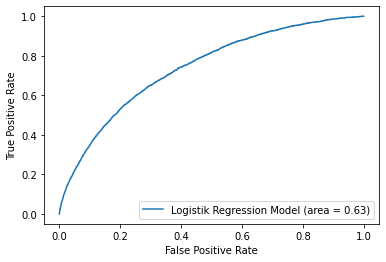

In [ ]:
Log_ROC_auc = roc_auc_score(y_test, y_pred_test_logres)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_logres [:, 1])

plt.figure()
plt.plot(fpr, tpr, label = "Logistik Regression Model (area = %0.2f)" % Log_ROC_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

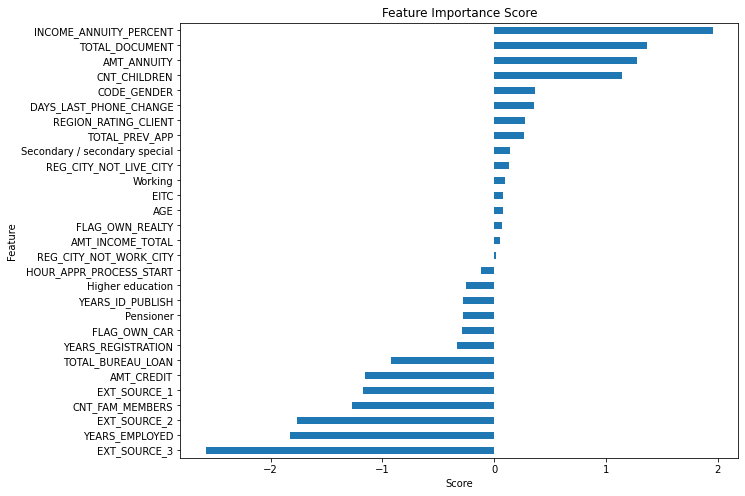

In [ ]:
feat_importances = pd.Series(logres.coef_[0], index=X.columns)
ax = feat_importances.nlargest(32).plot(kind='barh', figsize=(10, 8))
ax.invert_yaxis()

plt.xlabel('Score')
plt.ylabel('Feature')
plt.title('Feature Importance Score')
plt.show()

In [ ]:
feat_importances.abs().sort_values(ascending = False)

EXT_SOURCE_3                     2.578651
INCOME_ANNUITY_PERCENT           1.957353
YEARS_EMPLOYED                   1.824992
EXT_SOURCE_2                     1.764244
TOTAL_DOCUMENT                   1.366281
AMT_ANNUITY                      1.276945
CNT_FAM_MEMBERS                  1.274678
EXT_SOURCE_1                     1.171969
AMT_CREDIT                       1.158770
CNT_CHILDREN                     1.139281
TOTAL_BUREAU_LOAN                0.921286
CODE_GENDER                      0.367610
DAYS_LAST_PHONE_CHANGE           0.357122
YEARS_REGISTRATION               0.330628
FLAG_OWN_CAR                     0.290516
Pensioner                        0.279877
YEARS_ID_PUBLISH                 0.279585
REGION_RATING_CLIENT             0.271902
TOTAL_PREV_APP                   0.265475
Higher education                 0.253108
Secondary / secondary special    0.141960
REG_CITY_NOT_LIVE_CITY           0.129134
HOUR_APPR_PROCESS_START          0.118119
Working                          0

In [ ]:
cf = confusion_matrix(y_test, y_pred_test_logres)
cf

array([[49937,  6617],
       [ 3039,  1910]])

In [ ]:
y_pred_train_logres = logres.predict(X_train)
y_pred_test_logres = logres.predict(X_test)
print("Precision (Train Set): " +str(precision_score(y_train, y_pred_train_logres)))
print("Precision (Test Set):" +str(precision_score(y_test, y_pred_test_logres)))

Precision (Train Set): 0.6173515849727527
Precision (Test Set):0.22399437082209453


<b>Hyperparameter Tuning</b>

In [ ]:
# List Hyperparameters yang akan diuji
penalty = ['l2','l1','elasticnet']
C = [0.0001, 0.005] # Inverse of regularization strength; smaller values specify stronger regularization.
hyperparameters = dict(penalty=penalty, C=C)

# Inisiasi model
logres = LogisticRegression(random_state=42) # Init Logres dengan Gridsearch, cross validation = 5
logres_tuning = RandomizedSearchCV(logres, hyperparameters, cv=5, random_state=42, scoring='roc_auc')
logres_tuning.fit(X_train, y_train)

# Predict
y_pred_proba_logres_tuning = logres_tuning.predict_proba(X_test)
y_pred_test_logres_tuning = logres_tuning.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(

<b>Evaluation</b>

In [ ]:
eval_classification(logres_tuning, y_pred_test_logres_tuning, X_train, y_train, X_test, y_test)

Accuracy (Test Set): 0.85
Precision (Test Set): 0.23
Recall (Test Set): 0.37
F1-Score (Test Set): 0.28
AUC: 0.63


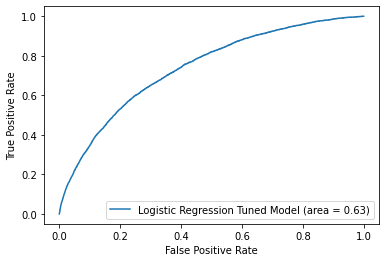

In [ ]:
Log_ROC_auc = roc_auc_score(y_test, y_pred_test_logres_tuning)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_logres_tuning [:, 1])

plt.figure()
plt.plot(fpr, tpr, label = "Logistic Regression Tuned Model (area = %0.2f)" % Log_ROC_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [ ]:
print('Best algorithm:', logres_tuning.best_estimator_.get_params()['penalty'])
print('Best C:', logres_tuning.best_estimator_.get_params()['C'])

Best algorithm: l2
Best C: 0.005


In [ ]:
cf = confusion_matrix(y_test, y_pred_test_logres_tuning)
cf

array([[50370,  6184],
       [ 3116,  1833]])

In [ ]:
y_pred_train = logres_tuning.predict(X_train)
y_pred_test = logres_tuning.predict(X_test)
print("Precision (Train Set): " +str(precision_score(y_train, y_pred_train)))
print("Precision (Test Set):" +str(precision_score(y_test, y_pred_test)))

Precision (Train Set): 0.6232802122797061
Precision (Test Set):0.2286391418236248


---

#### Decision Tree

In [ ]:
DT = DecisionTreeClassifier(random_state=42)
DT.fit(X_train,y_train)

# Predict
y_pred_proba_DT = DT.predict_proba(X_test)
y_pred_test_DT = DT.predict(X_test)

<b>Evaluation</b>

In [ ]:
eval_classification(DT, y_pred_test_DT, X_train, y_train, X_test, y_test)

Accuracy (Test Set): 0.83
Precision (Test Set): 0.12
Recall (Test Set): 0.18
F1-Score (Test Set): 0.15
AUC: 0.53


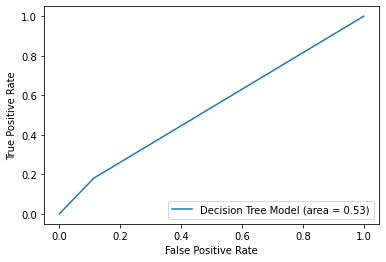

In [ ]:
Log_ROC_auc = roc_auc_score(y_test, y_pred_test_DT)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_DT [:, 1])

plt.figure()
plt.plot(fpr, tpr, label = "Decision Tree Model (area = %0.2f)" % Log_ROC_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [ ]:
cf = confusion_matrix(y_test, y_pred_test_DT)
cf

array([[50163,  6391],
       [ 4056,   893]])

<b>Regularization</b>

In [ ]:
# List of hyperparameter
max_depth = [int(x) for x in np.linspace(1, 110, num = 30)] # Maximum number of levels in tree
min_samples_split = [2, 5, 10, 100] # Minimum number of samples required to split a node
min_samples_leaf = [1, 2, 4, 10, 20, 50] # Minimum number of samples required at each leaf node
max_features = ['auto', 'sqrt'] # Number of features to consider at every split

hyperparameters = dict(max_depth=max_depth,
                       min_samples_split=min_samples_split,
                       min_samples_leaf=min_samples_leaf,
                       max_features=max_features
                      )

# Inisialisasi Model
DT = DecisionTreeClassifier(random_state=42)
DTreg = RandomizedSearchCV(DT, hyperparameters, cv=5, random_state=42, scoring='roc_auc')
DTreg.fit(X_train, y_train)

# Predict
y_pred_proba_DTreg = DTreg.predict_proba(X_test)
y_pred_test_DTreg = DTreg.predict(X_test)

<b>Evaluation</b>

In [ ]:
print('Best max_depth:', DTreg.best_estimator_.get_params()['max_depth'])
print('Best min_samples_split:', DTreg.best_estimator_.get_params()['min_samples_split'])
print('Best min_samples_leaf:', DTreg.best_estimator_.get_params()['min_samples_leaf'])
print('Best max_features:', DTreg.best_estimator_.get_params()['max_features'])

Best max_depth: 83
Best min_samples_split: 100
Best min_samples_leaf: 10
Best max_features: sqrt


In [ ]:
eval_classification(DTreg, y_pred_test_DTreg, X_train, y_train, X_test, y_test)

Accuracy (Test Set): 0.87
Precision (Test Set): 0.17
Recall (Test Set): 0.16
F1-Score (Test Set): 0.16
AUC: 0.54


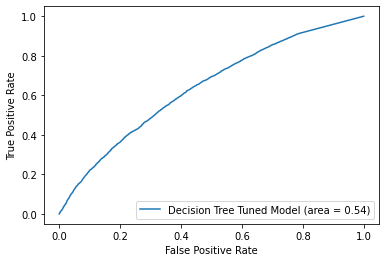

In [ ]:
Log_ROC_auc = roc_auc_score(y_test, y_pred_test_DTreg)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_DTreg [:, 1])

plt.figure()
plt.plot(fpr, tpr, label = "Decision Tree Tuned Model (area = %0.2f)" % Log_ROC_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [ ]:
cf = confusion_matrix(y_test, y_pred_test_DTreg)
cf

array([[52832,  3722],
       [ 4181,   768]])

---

#### Bagging: Random Forest

In [ ]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train,y_train)

# Predict
y_pred_proba_rf = rf.predict_proba(X_test)
y_pred_test_rf = rf.predict(X_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


<b>Evaluation</b>

In [ ]:
eval_classification(rf, y_pred_test_rf, X_train, y_train, X_test, y_test)

Accuracy (Test Set): 0.92
Precision (Test Set): 0.35
Recall (Test Set): 0.03
F1-Score (Test Set): 0.06
AUC: 0.51


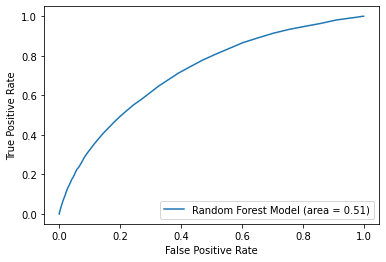

In [ ]:
Log_ROC_auc = roc_auc_score(y_test, y_pred_test_rf)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_rf [:, 1])

plt.figure()
plt.plot(fpr, tpr, label = "Random Forest Model (area = %0.2f)" % Log_ROC_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [ ]:
cf = confusion_matrix(y_test, y_pred_test_rf)
cf

array([[56256,   298],
       [ 4788,   161]])

<b>Hyperparameter Tuning</b>

In [ ]:
#List Hyperparameters yang akan diuji
hyperparameters = dict(
                       n_estimators = [int(x) for x in np.linspace(start = 10, stop = 20, num = 5)], # Jumlah subtree
                       bootstrap = [True], # Apakah pakai bootstrapping atau tidak
                       criterion = ['gini','entropy'],
                       max_depth = [int(x) for x in np.linspace(10, 20, num = 6)],  # Maximum kedalaman tree
                       min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 10, num = 5)], # Jumlah minimum samples pada node agar boleh di split menjadi leaf baru
                       min_samples_leaf = [int(x) for x in np.linspace(start = 1, stop = 10, num = 5)], # Jumlah minimum samples pada leaf agar boleh terbentuk leaf baru
                       max_features = ['auto', 'sqrt', 'log2'], # Jumlah feature yg dipertimbangkan pada masing-masing split
                       n_jobs = [-1], # Core untuk parallel computation. -1 untuk menggunakan semua core
                      )

# Init
rf = RandomForestClassifier(random_state=42)
rf_tuned = RandomizedSearchCV(rf, hyperparameters, cv=5, random_state=42, scoring='roc_auc')
rf_tuned.fit(X_train,y_train)

# Predict
y_pred_proba_rf_tuned = rf_tuned.predict_proba(X_test)
y_pred_test_rf_tuned = rf_tuned.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

<b>Evaluation</b>

In [ ]:
print('Best n_estimators:', rf_tuned.best_estimator_.get_params()['n_estimators'])
print('Best bootstrap:', rf_tuned.best_estimator_.get_params()['bootstrap'])
print('Best criterion:', rf_tuned.best_estimator_.get_params()['criterion'])
print('Best max_depth:', rf_tuned.best_estimator_.get_params()['max_depth'])
print('Best min_samples_split:', rf_tuned.best_estimator_.get_params()['min_samples_split'])
print('Best min_samples_leaf:', rf_tuned.best_estimator_.get_params()['min_samples_leaf'])
print('Best max_features:', rf_tuned.best_estimator_.get_params()['max_features'])
print('Best n_jobs:', rf_tuned.best_estimator_.get_params()['n_jobs'])

Best n_estimators: 12
Best bootstrap: True
Best criterion: entropy
Best max_depth: 20
Best min_samples_split: 2
Best min_samples_leaf: 5
Best max_features: log2
Best n_jobs: -1


In [ ]:
eval_classification(rf_tuned, y_pred_test_rf_tuned, X_train, y_train, X_test, y_test)

Accuracy (Test Set): 0.91
Precision (Test Set): 0.29
Recall (Test Set): 0.08
F1-Score (Test Set): 0.12
AUC: 0.53


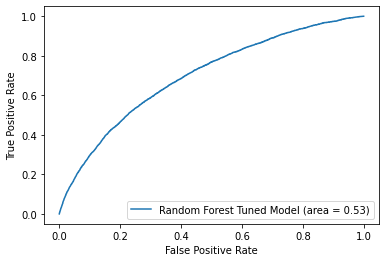

In [ ]:
Log_ROC_auc = roc_auc_score(y_test, y_pred_test_rf_tuned)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_rf_tuned [:, 1])

plt.figure()
plt.plot(fpr, tpr, label = "Random Forest Tuned Model (area = %0.2f)" % Log_ROC_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [ ]:
cf = confusion_matrix(y_test, y_pred_test_rf_tuned)
cf

array([[55645,   909],
       [ 4572,   377]])

---

#### XGBoost

In [ ]:
xg = XGBClassifier(random_state=42)
xg.fit(X_train, y_train)

# Predict
y_pred_proba_xg = xg.predict_proba(X_test)
y_pred_test_xg = xg.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


<b>Evaluation</b>

In [ ]:
eval_classification(xg, y_pred_test_xg, X_train, y_train, X_test, y_test)

Accuracy (Test Set): 0.92
Precision (Test Set): 0.37
Recall (Test Set): 0.02
F1-Score (Test Set): 0.04
AUC: 0.51


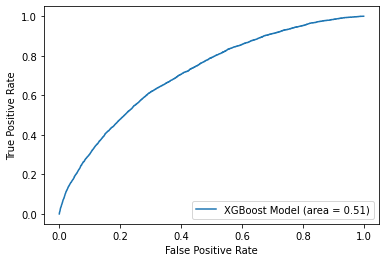

In [ ]:
Log_ROC_auc = roc_auc_score(y_test, y_pred_test_xg)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_xg [:, 1])

plt.figure()
plt.plot(fpr, tpr, label = "XGBoost Model (area = %0.2f)" % Log_ROC_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [ ]:
cf = confusion_matrix(y_test, y_pred_test_xg)
cf

array([[56392,   162],
       [ 4852,    97]])

<b>Hyperparameter Tuning</b>

In [ ]:
#Menjadikan ke dalam bentuk dictionary
hyperparameters = {
                    'max_depth' : [int(x) for x in np.linspace(10, 30, num = 6)],
                    'min_child_weight' : [int(x) for x in np.linspace(1, 20, num = 11)],
                    'gamma' : [float(x) for x in np.linspace(0, 1, num = 11)],
                    'tree_method' : ['auto', 'exact', 'approx', 'hist'],
                    'colsample_bytree' : [float(x) for x in np.linspace(0, 1, num = 11)],
                    'eta' : [float(x) for x in np.linspace(0, 1, num = 11)],
                    'lambda' : [float(x) for x in np.linspace(0, 1, num = 11)],
                    'alpha' : [float(x) for x in np.linspace(0, 1, num = 11)]
                    }

# Init
xg = XGBClassifier(random_state=42)
xg_tuned = RandomizedSearchCV(xg, hyperparameters, cv=5, random_state=42, scoring='roc_auc')
xg_tuned.fit(X_train,y_train)

# Predict
y_pred_proba_xg_tuned = xg_tuned.predict_proba(X_test)
y_pred_test_xg_tuned = xg_tuned.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), fo

<b>Evaluation</b>

In [ ]:
print('Best max_depth:', xg_tuned.best_estimator_.get_params()['max_depth'])
print('Best min_child_weight:', xg_tuned.best_estimator_.get_params()['min_child_weight'])
print('Best gamma:', xg_tuned.best_estimator_.get_params()['gamma'])
print('Best tree_method:', xg_tuned.best_estimator_.get_params()['tree_method'])
print('Best colsample_bytree:', xg_tuned.best_estimator_.get_params()['colsample_bytree'])
print('Best eta:', xg_tuned.best_estimator_.get_params()['eta'])
print('Best lambda:', xg_tuned.best_estimator_.get_params()['lambda'])
print('Best alpha:', xg_tuned.best_estimator_.get_params()['alpha'])

Best max_depth: 18
Best min_child_weight: 8
Best gamma: 0.4
Best tree_method: approx
Best colsample_bytree: 0.8
Best eta: 0.9
Best lambda: 0.1
Best alpha: 0.6000000000000001


In [ ]:
eval_classification(xg_tuned, y_pred_test_xg_tuned, X_train, y_train, X_test, y_test)

Accuracy (Test Set): 0.92
Precision (Test Set): 0.43
Recall (Test Set): 0.03
F1-Score (Test Set): 0.05
AUC: 0.51


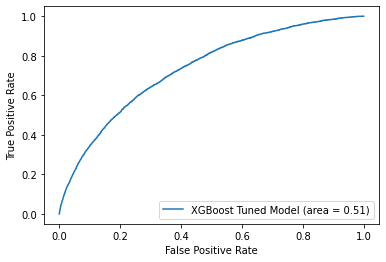

In [ ]:
Log_ROC_auc = roc_auc_score(y_test, y_pred_test_xg_tuned)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_xg_tuned [:, 1])

plt.figure()
plt.plot(fpr, tpr, label = "XGBoost Tuned Model (area = %0.2f)" % Log_ROC_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [ ]:
cf = confusion_matrix(y_test, y_pred_test_xg_tuned)
cf

array([[56383,   171],
       [ 4818,   131]])

### **Business Metrics Calculation**
Loss Given Default

In [ ]:
DF_TRAIN.shape

(307511, 205)

In [ ]:
DF_TRAIN.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,LANDAREA_AVG,LIVINGAREA_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,LANDAREA_MODE,LIVINGAREA_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,LANDAREA_MEDI,LIVINGAREA_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,TOTAL_PREV_APP,TOTAL_BUREAU_LOAN,AGE,YEARS_EMPLOYED,YEARS_REGISTRATION,YEARS_ID_PUBLISH,TOTAL_DOCUMENT,DOC_PROVIDED,INCOME_ANNUITY_PERCENT,INCOME_ANNUITY_PERCENT_NEW,EITC,Children,Family,Group of people,Other_A,Other_B,"Spouse, partner",Unaccompanied,Businessman,Commercial associate,Maternity leave,Pensioner,State servant,Student,Unemployed,Working,Academic degree,Higher education,Incomplete higher,Lower secondary,Secondary / secondary special,Civil marriage,Married,Separated,Single / not married,Unknown,Widow,Co-op apartment,House / apartment,Municipal apartment,Office apartment,Rented apartment,With parents,Accountants,Cleaning staff,Cooking staff,Core staff,Drivers,HR staff,High skill tech staff,IT staff,Laborers,Low-skill Laborers,Managers,Medicine staff,Private service staff,Realty agents,Sales staff,Secretaries,Security staff,Waiters/barmen staff,FRIDAY,MONDAY,SATURDAY,SUNDAY,THURSDAY,TUESDAY,WEDNESDAY,Advertising,Agriculture,Bank,Business Entity Type 1,Business Entity Type 2,Business Entity Type 3,Cleaning,Construction,Culture,Electricity,Emergency,Government,Hotel,Housing,Industry: type 1,Industry: type 10,Industry: type 11,Industry: type 12,Industry: type 13,Industry: type 2,Industry: type 3,Industry: type 4,Industry: type 5,Industry: type 6,Industry: type 7,Industry: type 8,Industry: type 9,Insurance,Kindergarten,Legal Services,Medicine,Military,Mobile,Other,Police,Postal,Realtor,Religion,Restaurant,School,Security,Security Ministries,Self-employed,Services,Telecom,Trade: type 1,Trade: type 2,Trade: type 3,Trade: type 4,Trade: type 5,Trade: type 6,Trade: type 7,Transport: type 1,Transport: type 2,Transport: type 3,Transport: type 4,University,block of flats,specific housing,terraced house,Block,Mixed,Monolithic,Others,Panel,"Stone, brick",Wooden
0,1,0,1,0,1,0.0,0.001512,0.090287,0.090032,0.077441,0.256321,1.0,1.0,0.0,1.0,1.0,0.0,0.000000,0.5,0.5,0.434783,0.0,0.0,0.0,0.0,0.0,0.0,0.072215,0.307542,0.155054,0.0247,0.0369,0.9722,0.00,0.0690,0.0833,0.0369,0.0190,0.0000,0.0252,0.0383,0.9722,0.0000,0.0690,0.0833,0.0377,0.0198,0.0000,0.0250,0.0369,0.9722,0.00,0.0690,0.0833,0.0375,0.0193,0.0000,0.0149,0,0.005747,0.058824,0.005814,0.083333,0.735788,0.0,0.0,0.0,0.0,0.0,0.04,0.000000,0.060870,0.111161,0.035563,0.147860,0.294567,0.25,1.0,0.064910,0.081181,0.023640,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0.0,0.002089,0.311736,0.132924,0.271605,0.045016,1.0,1.0,0.0,1.0,1.0,0.0,0.052632,0.0,0.0,0.478261,0.0,0.0,0.0,0.0,0.0,0.0,0.312933,0.

In [ ]:
DF_TRAIN['AMT_CREDIT'] = scaler_AMT_CREDIT.inverse_transform(DF_TRAIN['AMT_CREDIT'].values.reshape(len(DF_TRAIN), 1))

In [ ]:
DF_TRAIN.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,LANDAREA_AVG,LIVINGAREA_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,LANDAREA_MODE,LIVINGAREA_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,LANDAREA_MEDI,LIVINGAREA_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,TOTAL_PREV_APP,TOTAL_BUREAU_LOAN,AGE,YEARS_EMPLOYED,YEARS_REGISTRATION,YEARS_ID_PUBLISH,TOTAL_DOCUMENT,DOC_PROVIDED,INCOME_ANNUITY_PERCENT,INCOME_ANNUITY_PERCENT_NEW,EITC,Children,Family,Group of people,Other_A,Other_B,"Spouse, partner",Unaccompanied,Businessman,Commercial associate,Maternity leave,Pensioner,State servant,Student,Unemployed,Working,Academic degree,Higher education,Incomplete higher,Lower secondary,Secondary / secondary special,Civil marriage,Married,Separated,Single / not married,Unknown,Widow,Co-op apartment,House / apartment,Municipal apartment,Office apartment,Rented apartment,With parents,Accountants,Cleaning staff,Cooking staff,Core staff,Drivers,HR staff,High skill tech staff,IT staff,Laborers,Low-skill Laborers,Managers,Medicine staff,Private service staff,Realty agents,Sales staff,Secretaries,Security staff,Waiters/barmen staff,FRIDAY,MONDAY,SATURDAY,SUNDAY,THURSDAY,TUESDAY,WEDNESDAY,Advertising,Agriculture,Bank,Business Entity Type 1,Business Entity Type 2,Business Entity Type 3,Cleaning,Construction,Culture,Electricity,Emergency,Government,Hotel,Housing,Industry: type 1,Industry: type 10,Industry: type 11,Industry: type 12,Industry: type 13,Industry: type 2,Industry: type 3,Industry: type 4,Industry: type 5,Industry: type 6,Industry: type 7,Industry: type 8,Industry: type 9,Insurance,Kindergarten,Legal Services,Medicine,Military,Mobile,Other,Police,Postal,Realtor,Religion,Restaurant,School,Security,Security Ministries,Self-employed,Services,Telecom,Trade: type 1,Trade: type 2,Trade: type 3,Trade: type 4,Trade: type 5,Trade: type 6,Trade: type 7,Transport: type 1,Transport: type 2,Transport: type 3,Transport: type 4,University,block of flats,specific housing,terraced house,Block,Mixed,Monolithic,Others,Panel,"Stone, brick",Wooden
0,1,0,1,0,1,0.0,0.001512,406597.5,0.090032,0.077441,0.256321,1.0,1.0,0.0,1.0,1.0,0.0,0.000000,0.5,0.5,0.434783,0.0,0.0,0.0,0.0,0.0,0.0,0.072215,0.307542,0.155054,0.0247,0.0369,0.9722,0.00,0.0690,0.0833,0.0369,0.0190,0.0000,0.0252,0.0383,0.9722,0.0000,0.0690,0.0833,0.0377,0.0198,0.0000,0.0250,0.0369,0.9722,0.00,0.0690,0.0833,0.0375,0.0193,0.0000,0.0149,0,0.005747,0.058824,0.005814,0.083333,0.735788,0.0,0.0,0.0,0.0,0.0,0.04,0.000000,0.060870,0.111161,0.035563,0.147860,0.294567,0.25,1.0,0.064910,0.081181,0.023640,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0.0,0.002089,1293502.5,0.132924,0.271605,0.045016,1.0,1.0,0.0,1.0,1.0,0.0,0.052632,0.0,0.0,0.478261,0.0,0.0,0.0,0.0,0.0,0.0,0.312933,0

In [ ]:
X = DF_TRAIN.drop(columns = ['TARGET'])
Y = DF_TRAIN[['TARGET']]
XTrain, XTest, yTrain, yTest = train_test_split(X,Y,test_size = 0.2,random_state = 42)

In [ ]:
DF_TRAIN.shape

(307511, 205)

In [ ]:
y_pred_test_logres.shape

(61503,)

In [ ]:
XTest.shape

(61503, 204)

In [ ]:
XTest['TARGET_PRED_RESULT'] = y_pred_test_logres
XTest['TARGET'] = yTest

In [ ]:
XTest.shape

(61503, 206)

In [ ]:
XTest.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,LANDAREA_AVG,LIVINGAREA_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,LANDAREA_MODE,LIVINGAREA_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,LANDAREA_MEDI,LIVINGAREA_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,TOTAL_PREV_APP,TOTAL_BUREAU_LOAN,AGE,YEARS_EMPLOYED,YEARS_REGISTRATION,YEARS_ID_PUBLISH,TOTAL_DOCUMENT,DOC_PROVIDED,INCOME_ANNUITY_PERCENT,INCOME_ANNUITY_PERCENT_NEW,EITC,Children,Family,Group of people,Other_A,Other_B,"Spouse, partner",Unaccompanied,Businessman,Commercial associate,Maternity leave,Pensioner,State servant,Student,Unemployed,Working,Academic degree,Higher education,Incomplete higher,Lower secondary,Secondary / secondary special,Civil marriage,Married,Separated,Single / not married,Unknown,Widow,Co-op apartment,House / apartment,Municipal apartment,Office apartment,Rented apartment,With parents,Accountants,Cleaning staff,Cooking staff,Core staff,Drivers,HR staff,High skill tech staff,IT staff,Laborers,Low-skill Laborers,Managers,Medicine staff,Private service staff,Realty agents,Sales staff,Secretaries,Security staff,Waiters/barmen staff,FRIDAY,MONDAY,SATURDAY,SUNDAY,THURSDAY,TUESDAY,WEDNESDAY,Advertising,Agriculture,Bank,Business Entity Type 1,Business Entity Type 2,Business Entity Type 3,Cleaning,Construction,Culture,Electricity,Emergency,Government,Hotel,Housing,Industry: type 1,Industry: type 10,Industry: type 11,Industry: type 12,Industry: type 13,Industry: type 2,Industry: type 3,Industry: type 4,Industry: type 5,Industry: type 6,Industry: type 7,Industry: type 8,Industry: type 9,Insurance,Kindergarten,Legal Services,Medicine,Military,Mobile,Other,Police,Postal,Realtor,Religion,Restaurant,School,Security,Security Ministries,Self-employed,Services,Telecom,Trade: type 1,Trade: type 2,Trade: type 3,Trade: type 4,Trade: type 5,Trade: type 6,Trade: type 7,Transport: type 1,Transport: type 2,Transport: type 3,Transport: type 4,University,block of flats,specific housing,terraced house,Block,Mixed,Monolithic,Others,Panel,"Stone, brick",Wooden,TARGET_PRED_RESULT,TARGET
245895,0,1,1,0,0.105263,0.001550,465457.5,0.199000,0.094276,0.129331,1.0,1.0,0.0,1.0,0.0,0.0,0.157895,0.5,0.5,0.478261,0.0,0.0,0.0,0.0,1.0,1.0,0.697493,0.707479,0.000000,0.0876,0.0763,0.9816,0.00,0.1379,0.1667,0.0481,0.0745,0.0036,0.0840,0.0746,0.9816,0.0000,0.1379,0.1667,0.0458,0.0731,0.0011,0.0864,0.0758,0.9816,0.00,0.1379,0.1667,0.0487,0.0749,0.0031,0.0688,0,0.000000,0.0,0.000000,0.0,0.999534,0.0,0.0,0.0,0.037037,0.0,0.04,0.055556,0.052174,0.327396,0.042541,0.025819,0.598444,0.25,1.0,0.135456,0.169412,0.026481,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0
98194,0,0,1,1,0.000000,0.001897,1281712.5,0.184591,0.283951,0.090864,1.0,1.0,0.0,1.0,0.0,1.0,0.000000,1.0,1.0,0.434783,0

Loss Given Default Before Using Model

In [ ]:
Defaulters = XTest.groupby(['TARGET'])['AMT_CREDIT'].sum().reset_index()
Defaulters

,TARGET,AMT_CREDIT
0,0,3.390997e+10
1,1,2.780554e+09


In [ ]:
Total_Defaulters = XTest.groupby(['TARGET'])['AMT_CREDIT'].count().reset_index()
Total_Defaulters

,TARGET,AMT_CREDIT
0,0,56554
1,1,4949


In [ ]:
LGDBefore = Defaulters['AMT_CREDIT'].loc[Defaulters['TARGET'] == 1]
LGDBefore

1    2.780554e+09
Name: AMT_CREDIT, dtype: float64

### Loss Given Default After Using Model

In [ ]:
FalseNegative = (XTest.loc[(XTest['TARGET'] == 1) & (XTest['TARGET_PRED_RESULT'] == 0)])

In [ ]:
FalseNegative.shape

(3039, 206)

In [ ]:
LGDAfter = FalseNegative['AMT_CREDIT'].sum()
LGDAfter

1816980601.5

In [ ]:
LGDAfter - LGDBefore

1   -963573552.0
Name: AMT_CREDIT, dtype: float64

In [ ]:
LGD_Decreased_Percentage = ((LGDAfter-LGDBefore)/LGDBefore)*100
LGD_Decreased_Percentage

1   -34.654011
Name: AMT_CREDIT, dtype: float64

### **Predict Data Test Using Model**

In [ ]:
logres = LogisticRegression(random_state=42)
logres.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression(random_state=42)

In [ ]:
y_pred_proba_logres_df_test = logres.predict_proba(df_test)
y_pred_proba_logres_df_test

array([[0.57829869, 0.42170131],
       [0.26705167, 0.73294833],
       [0.67500646, 0.32499354],
       ...,
       [0.51378073, 0.48621927],
       [0.56878177, 0.43121823],
       [0.29891931, 0.70108069]])

In [ ]:
df_test.shape

(48744, 29)

In [ ]:
test.shape

(48744, 121)

In [ ]:
PredictResultTest = test['SK_ID_CURR'].reset_index()
PredictResultTest['TARGET'] = round(pd.DataFrame(y_pred_proba_logres_df_test[:,1]),1)
PredictResultTest.drop('index', axis=1, inplace=True)
PredictResultTest.head()

,SK_ID_CURR,TARGET
0,100001,0.4
1,100005,0.7
2,100013,0.3
3,100028,0.3
4,100038,0.6


In [ ]:
PredictResultTest.shape

(48744, 2)

In [ ]:
PredictResultTest.to_csv("y_pred_proba_df_test.txt", sep=',', header=True, index=False)